Notebook used to evaluate results. Very long, but the other option would have been to have multiple notebooks.

# Section 1: load imports, helper functions, and dataloaders

In [ ]:
!pip install transformers
!apt-get install git
!git clone https://github.com/lucalin17081994/Syntax-Enhanced-Bert/
%cd Syntax-Enhanced-Bert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.11).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Cloning into 'Syntax-Enhanced-Bert'...
remote: Enumerating objects: 1073, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 1073 (delta 134), reused 202 (delta 114), pack-reused 838
Receiving objects: 100% (1073/1073), 625.63 MiB | 38.57 MiB/s, done.
Resolving deltas: 100% (653/653), done.
Updating files: 100% (34/34), done.
Error downloading object: glove.6B.100d.txt (95dde4d): Smudge error:

In [ ]:
import Modules
from Modules import CA_Hesyfu, initialize_model, count_parameters,WarmupLinearSchedule
import Data
from Data import (
    read_dropna_encode_dataframe,
    read_data_pandas_snli,
    read_data_pandas,
    UnevenLengthDataset,
    get_batch_sup,
    dep_label_mappings,
    apply_clustering_dependency_labels

)
import Evaluation
from Evaluation import (
    get_hans_results,
    get_med_results,
    med_results_linguistic_phenomena,
    get_preds_from_logits,
    med_results_linguistic_phenomena,
    get_model_results_snli_mnli,
    get_hans_results_subcases,
    pickle_predictions,
    get_pickled_predictions,
    log_eval_metrics,
    eval_model_store_preds,
    train_batch,
    get_accuracy

)
import Tree_analysis
from Tree_analysis import calculate_dep_tree_similarity, calculate_const_tree_similarity, plot_tree_similarity, display_svg_side_by_side,tree_to_svg,dependency_tree_to_graphviz

import torch
import numpy as np
import pandas as pd
import time
import re
from sklearn import preprocessing
from typing import List, Tuple, Callable, Optional
from torch import FloatTensor, LongTensor
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tabulate import tabulate



In [ ]:
!git pull

Already up to date.


In [ ]:
from importlib import reload
# Reload the module containing the function
reload(Data)
reload(Modules)
reload(Evaluation)
reload(Tree_analysis)
# Reimport the functions
import Modules
from Modules import CA_Hesyfu, initialize_model, count_parameters,WarmupLinearSchedule
import Data
from Data import (
    read_dropna_encode_dataframe,
    read_data_pandas_snli,
    read_data_pandas,
    UnevenLengthDataset,
    get_batch_sup
)
import Evaluation
from Evaluation import (
    get_hans_results,
    get_med_results,
    med_results_linguistic_phenomena,
    get_preds_from_logits,
    med_results_linguistic_phenomena,
    get_model_results_snli_mnli,
    get_hans_results_subcases,
    pickle_predictions,
    get_pickled_predictions,
    log_eval_metrics,
    eval_model_store_preds,
    train_batch,
    get_accuracy

)
from Tree_analysis import calculate_dep_tree_similarity, calculate_const_tree_similarity, plot_tree_similarity

In [ ]:
if torch.cuda.is_available():
   print("Training on GPU")
   device = torch.device("cuda:0")
else:
  device=torch.device("cpu")

## wandb

In [ ]:
!pip install wandb -Uq
import wandb
wandb.login()
run_name="BERT"
run=wandb.init(reinit=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.2/213.2 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.6 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lucalin. Use `wandb login --relogin` to force relogin


## UNZIP DATA

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from zipfile import ZipFile
# specifying the zip file name
file_name = "/content/drive/MyDrive/evaluate_all.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()
file_name = "HANS_MED_original.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()
# file_name = "/content/drive/MyDrive/HANS_val_noGPU_processing.zip"
# with ZipFile(file_name, 'r') as zipfile:
#     zipfile.printdir()
#     zipfile.extractall()

Mounted at /content/drive
File Name                                             Modified             Size
HANS_val.pickle                                2023-02-09 14:17:24     20107672
MED_val.pickle                                 2023-01-31 13:10:58      3870134
SNLI_test.pickle                               2023-02-08 19:44:06      9076469
SNLI_test_hard.pickle                          2023-02-08 19:48:06      3161560
MNLI_val_mismatched.pickle                     2023-02-12 13:02:24     14007603
MNLI_val_matched.pickle                        2023-02-12 12:56:20     13300654
sick_test.pickle                               2023-02-27 19:16:34      3835803
File Name                                             Modified             Size
MED_ver_1.tsv                                  2022-03-17 09:16:02       786647
HANS_val_original.pickle                       2023-01-25 17:22:30     21176662


In [ ]:
#MNLI-m
file_name = "/content/drive/MyDrive/MNLI_m.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()
file_name = "/content/drive/MyDrive/MNLI_mm.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()

File Name                                             Modified             Size
MNLI_m.pickle                                  2023-05-29 08:13:28     13443189
File Name                                             Modified             Size
MNLI_mm.pickle                                 2023-05-29 08:26:36     14220811


In [ ]:
file_name = "SNLI_2validations.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()

# !wget https://nlp.stanford.edu/projects/snli/snli_1.0.zip
# with ZipFile('snli_1.0.zip', 'r') as zipfile:
#     zipfile.extractall()

File Name                                             Modified             Size
SNLI_val_hard.pickle                           2023-02-09 14:08:20      2838297
SNLI_train.pickle                              2023-02-08 19:31:44    471795666
SNLI_val.pickle                                2023-02-08 19:39:56      9090645


In [ ]:
# anli, lingnli, wanli
file_name = "anli_test.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()
file_name = "waNLI_test.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()
file_name = "lingNLI_test.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()

File Name                                             Modified             Size
anli_test.pickle                               2023-06-07 11:54:20      9725619
File Name                                             Modified             Size
waNLI_test.pickle                              2023-06-02 09:35:04      6318696
File Name                                             Modified             Size
lingNLI_test.pickle                            2023-06-02 09:29:22     10515048


In [ ]:
file_name = "anli_dev.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()

File Name                                             Modified             Size
anli_dev.pickle                                2023-06-07 11:44:50      9726649


In [ ]:
# from zipfile import ZipFile

# file_name = "SNLI_noHOB.zip"
# # file_name = "SICK.zip"

# with ZipFile(file_name, 'r') as zipfile:
#     zipfile.printdir()
#     zipfile.extractall()


In [ ]:
# df = pd.read_pickle("SNLI_train_noHOB.pickle")

# le = preprocessing.LabelEncoder()
# le.fit(['contradiction', 'entailment', 'neutral'])

# # Assuming your DataFrame is named 'df'
# integer_labels = np.argmax(df['gold_label'].to_numpy().tolist(), axis=1)

# decoded_labels = le.inverse_transform(integer_labels)

# # Add the decoded labels to the DataFrame as a new column
# df['decoded_gold_label'] = decoded_labels
# df['decoded_gold_label'].value_counts()


### Check new parses without GPU processing

In [ ]:
# original = pd.read_pickle('HANS_val.pickle')
# noGPU = pd.read_pickle('HANS_val_noGPU_processing.pickle')

# unequal_rows = original['heads_sentence1'].ne(noGPU['heads_sentence1'])

# noGPU[unequal_rows][['sentence1','heads_sentence1']]


In [ ]:
# snli_train= pd.read_pickle('SNLI_train.pickle')

# snli_train_original = pd.read_csv('snli_1.0/snli_1.0_train.txt', sep='\t', on_bad_lines='skip')#1



In [ ]:
# snli_train

In [ ]:
# unequal_rows = snli_train_original['sentence2_parse'].ne(snli_train['sentence2_parse'])
# len(unequal_rows)

In [ ]:
# snli_train_original[unequal_rows][['sentence2','sentence2_parse']]

In [ ]:
# original[unequal_rows][['sentence1','sentence1_parse']]
# contains_senator = orig['sentence1'].str.contains('senator')
# contains_senator.count()

### check hans parses, compare to He et al. (2020)

In [ ]:
# !pip install datasets
# #
# import csv
# from datasets import load_dataset

# # Load the SST-2 dataset
# dataset = load_dataset('hans')

# new = pd.read_pickle('HANS_val.pickle') #parsed with stanza
# new[['heads_sentence1','deprel_sentence1']]
# data = []
# with open('dependency_hans.tsv', 'r') as f:

#     for line in f:
#         sentence=[]
#         reader = csv.reader(f, delimiter='\t')
#         for row in reader:
#             if row:
#                 label, _, head, word, _ = row
#                 sentence.append([word,int(head),label])
#             else:
#                 words = [x[0] for x in sentence]
#                 heads = [x[1] for x in sentence]
#                 deprels = [x[2] for x in sentence]
#                 data.append([words,heads,deprels])
#                 sentence=[]
# df = pd.DataFrame({
#     'tokens': [row[0] for row in data],
#     'heads_sentence1': [row[1] for row in data],
#     'deprel_sentence1': [row[2] for row in data]
# })

# # indices = [1187,3447,1317,2760,2990,2559,4515,744,777,693]

# # df.loc[indices]['deprel_sentence1'].equals(new.loc[indices]['deprel_sentence1'])
# df['deprel_sentence1'].equals(new['deprel_sentence1'])

In [ ]:
# df = df.drop(df.index[0])
# new = new.drop(new.index[0])

# df['deprel_sentence1'].equals(new['deprel_sentence1'])

In [ ]:
# unequal_rows = df['heads_sentence1'].ne(new['heads_sentence1'])

# # Print the rows
# new[unequal_rows][['sentence1','heads_sentence1','deprel_sentence1']]

## READ DATA

In [ ]:
#hardcode some dict so i dont have to parse the training set again, also keeps vocabs consistent across conditions
dep_lb_to_idx= {'det': 0, 'nsubj': 1, 'case': 2, 'nmod': 3, 'root': 4, 'amod': 5, 'compound:prt': 6, 'obl': 7, 'punct': 8, 'aux': 9, 'nmod:poss': 10, 'obj': 11, 'cop': 12, 'advcl': 13, 'cc': 14, 'conj': 15, 'expl': 16, 'xcomp': 17, 'compound': 18, 'mark': 19, 'nummod': 20, 'advmod': 21, 'acl': 22, 'acl:relcl': 23, 'cc:preconj': 24, 'fixed': 25, 'nsubj:pass': 26, 'aux:pass': 27, 'ccomp': 28, 'appos': 29, 'iobj': 30, 'det:predet': 31, 'flat': 32, 'parataxis': 33, 'obl:tmod': 34, 'obl:agent': 35, 'discourse': 36, 'nmod:npmod': 37, 'goeswith': 38, 'csubj': 39, 'list': 40, 'obl:npmod': 41, 'dep': 42, 'reparandum': 43, 'nmod:tmod': 44, 'orphan': 45, 'dislocated': 46, 'vocative': 47, 'csubj:pass': 48}
# dep_lb_to_idx={'det': 0, 'nsubj': 1, 'case': 2, 'nmod': 3, 'root': 4, 'amod': 5, 'compund': 6, 'obl': 7, 'punct': 8, 'aux': 9, 'obj': 10,'cop': 11, 'advcl': 12, 'cc': 13, 'conj': 14, 'expl': 15, 'xcomp': 16, 'mark': 17, 'nummod': 18, 'advmod': 19, 'acl': 20, 'fixed': 21, 'nsubj:pass': 22, 'ccomp': 23, 'appos': 24, 'iobj': 25, 'parataxis': 26, 'obl:agent': 27, 'csubj': 28, 'mod': 29}
# dep_lb_to_idx={'det': 0, 'subj': 1, 'case': 2, 'mod': 3, 'root': 4, 'obl': 5, 'null': 6, 'obj': 7, 'xcomp': 8, 'mark': 9, 'subj:pass': 10, 'nsubj:pass': 11}
c_c_to_idx= {'NP': 0, 'DT': 1, 'NN': 2, 'PP': 3, 'IN': 4, 'S': 5, 'VP': 6, 'VBZ': 7, 'ADJP': 8, 'VBN': 9, 'RP': 10, '.': 11, 'VBG': 12, 'PRP$': 13, ',': 14, 'ADVP': 15, 'RB': 16, 'NNS': 17, 'CC': 18, 'PRP': 19, 'VBP': 20, 'EX': 21, 'JJ': 22, 'JJR': 23, 'SBAR': 24, 'TO': 25, 'VB': 26, 'CD': 27, 'HYPH': 28, 'WHNP': 29, 'WP': 30, 'VBD': 31, 'PRT': 32, 'NML': 33, 'NNP': 34, 'WHADVP': 35, 'WRB': 36, 'WDT': 37, 'POS': 38, 'QP': 39, 'WHADJP': 40, 'MD': 41, '``': 42, 'NNPS': 43, "''": 44, 'PDT': 45, 'RBR': 46, 'JJS': 47, 'UH': 48, 'UCP': 49, 'WHPP': 50, 'AFX': 51, 'SYM': 52, 'SINV': 53, 'X': 54, 'CONJP': 55, 'NFP': 56, 'FRAG': 57, 'WP$': 58, ':': 59, '-LRB-': 60, '-RRB-': 61, 'SBARQ': 62, 'SQ': 63, 'FW': 64, 'PRN': 65, 'INTJ': 66, 'RBS': 67, '$': 68, 'ADD': 69, 'RRC': 70, 'LST': 71, 'LS': 72, 'GW': 73}
w_c_to_idx= {'S': 0, 'NP': 1, 'DT': 2, 'NN': 3, 'PP': 4, 'IN': 5, 'VP': 6, 'VBZ': 7, 'ADJP': 8, 'VBN': 9, 'RP': 10, '.': 11, 'VBG': 12, 'PRP$': 13, ',': 14, 'ADVP': 15, 'RB': 16, 'NNS': 17, 'CC': 18, 'PRP': 19, 'VBP': 20, 'EX': 21, 'JJ': 22, 'JJR': 23, 'SBAR': 24, 'TO': 25, 'VB': 26, 'CD': 27, 'HYPH': 28, 'WHNP': 29, 'WP': 30, 'VBD': 31, 'PRT': 32, 'NML': 33, 'NNP': 34, 'WHADVP': 35, 'WRB': 36, 'WDT': 37, 'POS': 38, 'QP': 39, 'WHADJP': 40, 'MD': 41, '``': 42, 'NNPS': 43, "''": 44, 'PDT': 45, 'RBR': 46, 'JJS': 47, 'UH': 48, 'UCP': 49, 'WHPP': 50, 'AFX': 51, 'SYM': 52, 'SINV': 53, 'X': 54, 'CONJP': 55, 'NFP': 56, 'FRAG': 57, 'WP$': 58, ':': 59, '-LRB-': 60, '-RRB-': 61, 'SBARQ': 62, 'SQ': 63, 'FW': 64, 'PRN': 65, 'INTJ': 66, 'RBS': 67, '$': 68, 'ADD': 69, 'RRC': 70, 'LST': 71, 'LS': 72, 'GW': 73}

#for mnli
# dep_lb_to_idx={'det': 0, 'nsubj': 1, 'case': 2, 'nmod': 3, 'root': 4, 'amod': 5, 'compound:prt': 6, 'obl': 7, 'punct': 8, 'aux': 9, 'nmod:poss': 10, 'obj': 11, 'cop': 12, 'advcl': 13, 'cc': 14, 'conj': 15, 'expl': 16, 'xcomp': 17, 'compound': 18, 'mark': 19, 'nummod': 20, 'advmod': 21, 'acl': 22, 'acl:relcl': 23, 'cc:preconj': 24, 'fixed': 25, 'nsubj:pass': 26, 'aux:pass': 27, 'ccomp': 28, 'appos': 29, 'iobj': 30, 'det:predet': 31, 'flat': 32, 'parataxis': 33, 'obl:tmod': 34, 'obl:agent': 35, 'discourse': 36, 'nmod:npmod': 37, 'goeswith': 38, 'csubj': 39, 'list': 40, 'obl:npmod': 41, 'dep': 42, 'reparandum': 43, 'nmod:tmod': 44, 'orphan': 45, 'dislocated': 46, 'vocative': 47, 'csubj:pass': 48, 'nsubj:outer': 49, 'advcl:relcl': 50, 'csubj:outer': 51}
#big dataset
# dep_lb_to_idx={'det': 0, 'nsubj': 1, 'case': 2, 'nmod': 3, 'root': 4, 'amod': 5, 'compound:prt': 6, 'obl': 7, 'punct': 8, 'aux': 9, 'nmod:poss': 10, 'obj': 11, 'cop': 12, 'advcl': 13, 'cc': 14, 'conj': 15, 'expl': 16, 'xcomp': 17, 'compound': 18, 'mark': 19, 'nummod': 20, 'advmod': 21, 'acl': 22, 'acl:relcl': 23, 'cc:preconj': 24, 'fixed': 25, 'nsubj:pass': 26, 'aux:pass': 27, 'ccomp': 28, 'appos': 29, 'iobj': 30, 'det:predet': 31, 'flat': 32, 'parataxis': 33, 'obl:tmod': 34, 'obl:agent': 35, 'discourse': 36, 'nmod:npmod': 37, 'goeswith': 38, 'csubj': 39, 'list': 40, 'obl:npmod': 41, 'dep': 42, 'reparandum': 43, 'nmod:tmod': 44, 'orphan': 45, 'dislocated': 46, 'vocative': 47, 'csubj:pass': 48, 'nsubj:outer': 49, 'advcl:relcl': 50, 'csubj:outer': 51, 'flat:foreign':52}


In [ ]:
# Define label encoder and fit it to the gold label values
le = preprocessing.LabelEncoder()
le.fit(['contradiction', 'entailment', 'neutral'])

# Read data from various pickle files and preprocess it
snli_test = read_dropna_encode_dataframe('SNLI_test.pickle', le, False, is_hans=False, is_mnli=False)
snli_test_hard = read_dropna_encode_dataframe('SNLI_test_hard.pickle', le, False, is_hans=False, is_mnli=False)
hans = read_dropna_encode_dataframe('HANS_val.pickle', le, False, is_hans=True, is_mnli=False)
med = read_dropna_encode_dataframe('MED_val.pickle', le, False, is_hans=False, is_mnli=False)
# mnli_m = read_dropna_encode_dataframe('MNLI_val_matched.pickle', le, False, is_hans=False, is_mnli=True)
# mnli_mm = read_dropna_encode_dataframe('MNLI_val_mismatched.pickle', le, False, is_hans=False, is_mnli=True)
mnli_m = read_dropna_encode_dataframe('MNLI_m.pickle', le, False, is_hans=False, is_mnli=True)
mnli_mm = read_dropna_encode_dataframe('MNLI_mm.pickle', le, False, is_hans=False, is_mnli=True)
# sick = read_dropna_encode_dataframe('sick_test.pickle', le, False, is_hans=False, is_mnli=False)
# anli=read_dropna_encode_dataframe('anli_test.pickle', le, False, is_hans=False, is_mnli=False)
# anli=read_dropna_encode_dataframe('anli_dev.pickle', le, False, is_hans=False, is_mnli=False)
# anli = anli.reset_index(drop=True)
# anli = anli.drop([2167,2172])
# anli = anli.reset_index(drop=True)
# wanli=read_dropna_encode_dataframe('waNLI_test.pickle', le, False, is_hans=False, is_mnli=False)
# lingnli=read_dropna_encode_dataframe('lingNLI_test.pickle', le, False, is_hans=False, is_mnli=False)

# snli_test = apply_clustering_dependency_labels(snli_test, dep_label_mappings, -1)
# snli_test_hard = apply_clustering_dependency_labels(snli_test_hard, dep_label_mappings, -1)
# hans = apply_clustering_dependency_labels(hans, dep_label_mappings, -1)
# med = apply_clustering_dependency_labels(med, dep_label_mappings, -1)
# mnli_m = apply_clustering_dependency_labels(mnli_m, dep_label_mappings, -1)
# mnli_mm = apply_clustering_dependency_labels(mnli_mm, dep_label_mappings, -1)

# Preprocess the data using the read_data_pandas function and print the number of examples in each dataset
dev, w_c_to_idx, c_c_to_idx, dep_lb_to_idx = read_data_pandas(snli_test, w_c_to_idx, c_c_to_idx, dep_lb_to_idx)
print("SNLI-test examples", len(dev))

dev2, w_c_to_idx, c_c_to_idx, dep_lb_to_idx = read_data_pandas(snli_test_hard, w_c_to_idx, c_c_to_idx, dep_lb_to_idx)
print("SNLI-test-hard examples", len(dev2))

dev3, w_c_to_idx, c_c_to_idx, dep_lb_to_idx = read_data_pandas(hans, w_c_to_idx, c_c_to_idx, dep_lb_to_idx)
print("HANS examples", len(dev3))

dev4, w_c_to_idx, c_c_to_idx, dep_lb_to_idx = read_data_pandas(med, w_c_to_idx, c_c_to_idx, dep_lb_to_idx)
print("MED examples", len(dev4))

dev5, w_c_to_idx, c_c_to_idx, dep_lb_to_idx = read_data_pandas(mnli_m, w_c_to_idx, c_c_to_idx, dep_lb_to_idx)
print("MNLI-m examples", len(dev5))

dev6, w_c_to_idx, c_c_to_idx, dep_lb_to_idx = read_data_pandas(mnli_mm, w_c_to_idx, c_c_to_idx, dep_lb_to_idx)
print("MNLI-mm examples", len(dev6))

# dev7, w_c_to_idx, c_c_to_idx, dep_lb_to_idx = read_data_pandas(sick, w_c_to_idx, c_c_to_idx, dep_lb_to_idx)
# print("SICK examples", len(dev7))

# dev7, w_c_to_idx, c_c_to_idx, dep_lb_to_idx = read_data_pandas(anli, w_c_to_idx, c_c_to_idx, dep_lb_to_idx)
# print("anli examples", len(dev7))
# dev8, w_c_to_idx, c_c_to_idx, dep_lb_to_idx = read_data_pandas(wanli, w_c_to_idx, c_c_to_idx, dep_lb_to_idx)
# print("wanli examples", len(dev8))
# dev9, w_c_to_idx, c_c_to_idx, dep_lb_to_idx = read_data_pandas(lingnli, w_c_to_idx, c_c_to_idx, dep_lb_to_idx)
# print("lingnli examples", len(dev9))


SNLI-test examples 9824
SNLI-test-hard examples 3261
HANS examples 30000
MED examples 5382


KeyboardInterrupt: ignored

In [ ]:
dep_lb_to_idx

In [ ]:
#labels
le.inverse_transform([0,1,2])

## DATALOADER


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define data loaders for various datasets
datasets = [dev, dev2, dev3, dev4, dev5, dev6]
batch_sizes = [32, 32, 32, 32,8,8]

# datasets = [dev5, dev6]
# batch_sizes = [8,8]

# datasets = [dev3]
# batch_sizes = [32]

dataloaders = []
for dataset, batch_size in zip(datasets, batch_sizes):
    dataset = UnevenLengthDataset(dataset, tokenizer)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: get_batch_sup(batch, device, dep_lb_to_idx, True, True))
    dataloaders.append(dataloader)
val_dataloader_snli, val_dataloader_snli_hard, val_dataloader_hans, val_dataloader_med,val_dataloader_mnli_m, val_dataloader_mnli_mm = dataloaders
# val_dataloader_hans = dataloaders[0]
# val_dataloader_snli, val_dataloader_snli_hard= dataloaders
# val_dataloader_mnli_m, val_dataloader_mnli_mm = dataloaders


In [ ]:
# Define data loaders for various datasets
# dev7 = anli
# dev8 = wanli
# dev9 = lingnli
# datasets = [dev7,dev8,dev9]
# batch_sizes = [8,8,8]


# dataloaders = []
# for dataset, batch_size in zip(datasets, batch_sizes):
#     dataset = UnevenLengthDataset(dataset, tokenizer)
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: get_batch_sup(batch, device, dep_lb_to_idx, True, True))
#     dataloaders.append(dataloader)
# val_dataloader_anli, val_dataloader_wanli, val_dataloader_lingnli = dataloaders

## 1. Load True labels
get the true labels of each evaluation set. Should have unzipped and applied read_dropna_encode_dataframe from section 1


*   SNLI test
*   SNLI test hard
*   MNLI matched
*   MNLI mismatched
*   HANS validation set
*   MED



In [ ]:
import numpy as np

def get_true_labels(dataset):
    # Labels are one-hot-encoded, so turn them back to labels
    true_labels = [np.argmax(x) for x in dataset['gold_label'].values]
    return true_labels
true_snli_test = get_true_labels(snli_test)
true_snli_test_hard = get_true_labels(snli_test_hard)
true_mnli_m = get_true_labels(mnli_m)
true_mnli_mm = get_true_labels(mnli_mm)
true_hans = get_true_labels(hans)
true_med = get_true_labels(med)
# true_sick = get_true_labels(sick)

# true_anli = get_true_labels(anli)
# true_wanli = get_true_labels(wanli)
# true_lingnli = get_true_labels(lingnli)

# Section 2: save single model predictions
you can get the features by loading the dataset used to evaluate

## 0.prepare datasets helper function




In [ ]:

def load_datasets(model_name):
    '''
    make it easier to load the datasets.
    datasets[0] = output filename
    datasets[1] = dataloader object
    '''
    datasets = [
        # (model_name+'_preds_snli_test_hard.pickle', val_dataloader_snli_hard),
        # (model_name+'_preds_snli_test.pickle', val_dataloader_snli),
        # (model_name+'_preds_mnli_m.pickle', val_dataloader_mnli_m),
        # (model_name+'_preds_mnli_mm.pickle', val_dataloader_mnli_mm),
        # (model_name+'_preds_hans.pickle', val_dataloader_hans),
        # (model_name+'_preds_med.pickle', val_dataloader_med),
        # (model_name+'_preds_sick.pickle', val_dataloader_sick)
        (model_name+'_preds_anli.pickle', val_dataloader_anli),
        # (model_name+'_preds_wanli.pickle', val_dataloader_wanli),
        # (model_name+'_preds_lingnli.pickle', val_dataloader_lingnli),
        ]
    return datasets

## 1.Base model

In [ ]:
#load base model
#def initialize_model(gcn_dim, L, dep_lb_to_idx, w_c_to_idx, c_c_to_idx, device, use_constGCN=True, use_depGCN=True):

base, model_name = initialize_model(None,None,None,None,None,device,use_constGCN=False,use_depGCN=False)
artifact = run.use_artifact('lucalin/MNLI_3_epochs/base.pth:v0', type='model')
artifact_dir = artifact.download()
base.load_state_dict(torch.load(artifact_dir+'/base.pth'))

loss_fn = nn.CrossEntropyLoss()
base.to(device)

datasets=load_datasets(model_name)
for output_file_name, dataloader in datasets:
    print('evaluating', output_file_name)
    loss, val_accuracy, logits = eval_model_store_preds(base, dataloader, loss_fn, device, is_syntax_enhanced=False)
    preds = get_preds_from_logits(logits, add_contradiction_and_neutral=(output_file_name == 'base_preds_hans.pickle'or output_file_name == 'base_preds_med.pickle'))
    # preds = get_preds_from_logits(logits, add_contradiction_and_neutral=False)
    pickle_predictions(output_file_name, preds)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

model name: base
Total parameters = 109484547


wandb: Downloading large artifact base.pth:v0, 417.73MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:28.4


evaluating base_preds_anli.pickle


In [ ]:
# m = nn.Softmax(dim=0)
# softmax_probs = [m(item) for sublist in logits for item in sublist]
# added_counts = 0
# c_count, n_count= 0,0
# total=0
# for s in softmax_probs:
#     n = s[2]
#     c = s[0]
#     n_and_c = s[0]+s[2]
#     if n_and_c > 0.5 and n<0.5 and c<0.5:
#         added_counts += 1
#     if n>0.5:
#         n+=1
#     if c>0.5:
#         c+=1
#     if n_and_c>0.5:
#         total+=1
# print(n,c,added_counts, total, added_counts/total)

#check how many cases have c+n>0.5
# m = nn.Softmax(dim=0)
# softmax_probs = [m(item) for sublist in logits for item in sublist]
# added_counts = 0
# total=0
# for s in softmax_probs:
#     n = s[2]
#     c = s[0]
#     n_and_c = s[0]+s[2]
#     if n_and_c > 0.5 and n<0.5 and c<0.5:
#         added_counts += 1
#     if n_and_c>0.5:
#         total+=1
# print(added_counts, total, added_counts/total)

In [ ]:
# df=pd.DataFrame({'preds':preds})
# df.value_counts()

## 2.constGCN
datasets = tuple containing output file name + corresponding dataloader

In [ ]:
model, model_name = initialize_model(768, 1, dep_lb_to_idx, w_c_to_idx, c_c_to_idx, device, use_constGCN=True, use_depGCN=False)
artifact = run.use_artifact('lucalin/MNLI_3_epochs/constGCN.pth:v0', type='model')
artifact_dir = artifact.download()
model.load_state_dict(torch.load(artifact_dir+'/'+model_name+'.pth'))

loss_fn = nn.CrossEntropyLoss()
model.to(device)

datasets=load_datasets(model_name)
for output_file_name, dataloader in datasets:#<- load datasets first
    print('evaluating', output_file_name)
    loss, val_accuracy, logits = eval_model_store_preds(model, dataloader, loss_fn, device, is_syntax_enhanced=True)
    preds = get_preds_from_logits(logits, add_contradiction_and_neutral=(output_file_name == model_name+'_preds_hans.pickle'or output_file_name == model_name+'_preds_med.pickle'))
    # preds = get_preds_from_logits(logits, add_contradiction_and_neutral=False)
    pickle_predictions(output_file_name, preds)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model name: constGCN
Total parameters = 115742655


wandb: Downloading large artifact constGCN.pth:v0, 441.61MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:25.3


evaluating constGCN_preds_anli.pickle


In [ ]:
# m = nn.Softmax(dim=0)
# softmax_probs = [m(item) for sublist in logits for item in sublist]
# added_counts = 0
# total=0
# for s in softmax_probs:
#     n = s[2]
#     c = s[0]
#     n_and_c = s[0]+s[2]
#     if n_and_c > 0.5 and n<0.5 and c<0.5:
#         added_counts += 1
#     if n_and_c>0.5:
#         total+=1
# print(added_counts, total, added_counts/total)


In [ ]:
# df=pd.DataFrame({'preds':preds})
# df.value_counts()

## 3.depGCN

In [ ]:
model, model_name = initialize_model(768, 1, dep_lb_to_idx, w_c_to_idx, c_c_to_idx, device, use_constGCN=False, use_depGCN=True)
artifact = run.use_artifact('lucalin/MNLI_3_epochs/depGCN.pth:v0', type='model')
artifact_dir = artifact.download()
model.load_state_dict(torch.load(artifact_dir+'/'+model_name+'.pth'))

loss_fn = nn.CrossEntropyLoss()
model.to(device)

datasets=load_datasets(model_name)

for output_file_name, dataloader in datasets:
    print('evaluating', output_file_name)
    loss, val_accuracy, logits = eval_model_store_preds(model, dataloader, loss_fn, device, is_syntax_enhanced=True)
    preds = get_preds_from_logits(logits, add_contradiction_and_neutral=(output_file_name == model_name+'_preds_hans.pickle' or output_file_name == model_name+'_preds_med.pickle'))
    # preds = get_preds_from_logits(logits, add_contradiction_and_neutral=False)
    pickle_predictions(output_file_name, preds)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model name: depGCN
Total parameters = 113074947


wandb: Downloading large artifact depGCN.pth:v0, 431.43MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:26.4


evaluating depGCN_preds_anli.pickle


In [ ]:
# #check how many cases have c+n>0.5
# m = nn.Softmax(dim=0)
# softmax_probs = [m(item) for sublist in logits for item in sublist]
# added_counts = 0
# total=0
# for s in softmax_probs:
#     n = s[2]
#     c = s[0]
#     n_and_c = s[0]+s[2]
#     if n_and_c > 0.5 and n<0.5 and c<0.5:
#         added_counts += 1
#     if n_and_c>0.5:
#         total+=1
# print(added_counts, total, added_counts/total)

In [ ]:
# df=pd.DataFrame({'preds':preds})
# df.value_counts()

## 4.CAHesyfu (depGCN + constGCN)

In [ ]:
model, model_name = initialize_model(768, 1, dep_lb_to_idx, w_c_to_idx, c_c_to_idx, device, use_constGCN=True, use_depGCN=True)
artifact = run.use_artifact('lucalin/MNLI_3_epochs/cahesyfu.pth:v0', type='model')
artifact_dir = artifact.download()
model.load_state_dict(torch.load(artifact_dir+'/'+model_name+'.pth'))

loss_fn = nn.CrossEntropyLoss()
model.to(device)

datasets=load_datasets(model_name)

for output_file_name, dataloader in datasets:
    print('evaluating', output_file_name)
    loss, val_accuracy, logits = eval_model_store_preds(model, dataloader, loss_fn, device, is_syntax_enhanced=True)
    preds = get_preds_from_logits(logits, add_contradiction_and_neutral=(output_file_name == model_name+'_preds_hans.pickle' or output_file_name == model_name+'_preds_med.pickle'))
    # preds = get_preds_from_logits(logits, add_contradiction_and_neutral=False)
    pickle_predictions(output_file_name, preds)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model name: cahesyfu
Total parameters = 117555135


wandb: Downloading large artifact cahesyfu.pth:v0, 448.53MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:36.0


evaluating cahesyfu_preds_anli.pickle


# Section 3: RESULTS, accuracy on each test set


## 2. SNLI + MNLI (+SICK)

model name and the 4 lists containing labels of each of the following evaluation sets: SNLI-test, SNLI-test-hard, MNLI-matched, MNLI-mismatched

In [ ]:
def get_model_results_snli(model_name, true_snli_test, true_snli_test_hard):
    results = [model_name]
    results.append(get_accuracy(get_pickled_predictions(model_name + '_preds_snli_test.pickle'), true_snli_test))
    results.append(get_accuracy(get_pickled_predictions(model_name + '_preds_snli_test_hard.pickle'), true_snli_test_hard))
    return results

In [ ]:
# base_results = get_model_results_snli('base', true_snli_test, true_snli_test_hard)
constGCN_results = get_model_results_snli('constGCN', true_snli_test, true_snli_test_hard)

rows= [['Model', 'SNLI-test', 'SNLI-test-hard','MNLI-m', 'MNLI-mm'],
      #  base_results,
       constGCN_results,
       ]
print('test sets results:')
print(tabulate(rows, headers='firstrow'))
print('\nTabulate Latex:')
print(tabulate(rows, headers='firstrow', tablefmt='latex'))

test sets results:
Model       SNLI-test    SNLI-test-hard
--------  -----------  ----------------
constGCN      90.7471           81.1714

Tabulate Latex:
\begin{tabular}{lrr}
\hline
 Model    &   SNLI-test &   SNLI-test-hard \\
\hline
 constGCN &     90.7471 &          81.1714 \\
\hline
\end{tabular}


In [ ]:
def get_model_results_anli_wanli_lingnli(model_name, true_anli, true_wanli, true_lingnli):
    results = [model_name]
    results.append(get_accuracy(get_pickled_predictions(model_name + '_preds_anli.pickle'), true_anli))
    results.append(get_accuracy(get_pickled_predictions(model_name + '_preds_wanli.pickle'), true_wanli))
    results.append(get_accuracy(get_pickled_predictions(model_name + '_preds_lingnli.pickle'), true_lingnli))
    return results



In [ ]:
base_results = get_model_results_snli_mnli('base', true_snli_test, true_snli_test_hard, true_mnli_m, true_mnli_mm)
constGCN_results = get_model_results_snli_mnli('constGCN', true_snli_test, true_snli_test_hard, true_mnli_m, true_mnli_mm)
depGCN_results = get_model_results_snli_mnli('depGCN', true_snli_test, true_snli_test_hard, true_mnli_m, true_mnli_mm)
cahesyfu_results = get_model_results_snli_mnli('cahesyfu', true_snli_test, true_snli_test_hard, true_mnli_m, true_mnli_mm)

#SICK
# base_results.append(get_accuracy(get_pickled_predictions('base_preds_sick.pickle'), true_sick))
# constGCN_results.append(get_accuracy(get_pickled_predictions('constGCN_preds_sick.pickle'), true_sick))
# depGCN_results.append(get_accuracy(get_pickled_predictions('depGCN_preds_sick.pickle'), true_sick))
# cahesyfu_results.append(get_accuracy(get_pickled_predictions('cahesyfu_preds_sick.pickle'), true_sick))

rows= [['Model', 'SNLI-test', 'SNLI-test-hard','MNLI-m', 'MNLI-mm'],
       base_results,
       constGCN_results,
       depGCN_results,
       cahesyfu_results
       ]
print('test sets results:')
print(tabulate(rows, headers='firstrow'))
print('\nTabulate Latex:')
print(tabulate(rows, headers='firstrow', tablefmt='latex'))

test sets results:
Model       SNLI-test    SNLI-test-hard    MNLI-m    MNLI-mm
--------  -----------  ----------------  --------  ---------
base          78.2268           70.0092   84.218     84.1843
constGCN      77.7484           68.6293   84.1977    84.4284
depGCN        77.728            68.7519   84.3301    83.9809
cahesyfu      77.7484           68.6293   84.5033    84.1233

Tabulate Latex:
\begin{tabular}{lrrrr}
\hline
 Model    &   SNLI-test &   SNLI-test-hard &   MNLI-m &   MNLI-mm \\
\hline
 base     &     78.2268 &          70.0092 &  84.218  &   84.1843 \\
 constGCN &     77.7484 &          68.6293 &  84.1977 &   84.4284 \\
 depGCN   &     77.728  &          68.7519 &  84.3301 &   83.9809 \\
 cahesyfu &     77.7484 &          68.6293 &  84.5033 &   84.1233 \\
\hline
\end{tabular}


## ANLI, WaNLI, LingNLI

In [ ]:
base_results = get_model_results_anli_wanli_lingnli('base', true_anli, true_wanli, true_lingnli)
constGCN_results = get_model_results_anli_wanli_lingnli('constGCN', true_anli, true_wanli, true_lingnli)
depGCN_results = get_model_results_anli_wanli_lingnli('depGCN', true_anli, true_wanli, true_lingnli)
cahesyfu_results = get_model_results_anli_wanli_lingnli('cahesyfu', true_anli, true_wanli, true_lingnli)

rows= [['Model', 'ANLI', 'WaNLI', 'LingNLI'],
       base_results,
       constGCN_results,
       depGCN_results,
       cahesyfu_results
       ]
print('test sets results:')
print(tabulate(rows, headers='firstrow'))
print('\nTabulate Latex:')
print(tabulate(rows, headers='firstrow', tablefmt='latex'))

test sets results:
Model        ANLI    WaNLI    LingNLI
--------  -------  -------  ---------
base      48.7812    70.62    77.6964
constGCN  47.8125    70.4     77.1266
depGCN    47.25      71.46    77.208
cahesyfu  45.9062    70.64    77.0723

Tabulate Latex:
\begin{tabular}{lrrr}
\hline
 Model    &    ANLI &   WaNLI &   LingNLI \\
\hline
 base     & 48.7812 &   70.62 &   77.6964 \\
 constGCN & 47.8125 &   70.4  &   77.1266 \\
 depGCN   & 47.25   &   71.46 &   77.208  \\
 cahesyfu & 45.9062 &   70.64 &   77.0723 \\
\hline
\end{tabular}


## ANLI only

In [ ]:
def get_model_results_anli(model_name, true_anli):
    results = [model_name]
    results.append(get_accuracy(get_pickled_predictions(model_name + '_preds_anli.pickle'), true_anli))
    return results

In [ ]:
base_results = get_model_results_anli('base', true_anli)
constGCN_results = get_model_results_anli('constGCN', true_anli)
depGCN_results = get_model_results_anli('depGCN', true_anli)
cahesyfu_results = get_model_results_anli('cahesyfu', true_anli)

rows= [['Model', 'ANLI'],
       base_results,
       constGCN_results,
       depGCN_results,
       cahesyfu_results
       ]
print('test sets results:')
print(tabulate(rows, headers='firstrow'))
print('\nTabulate Latex:')
print(tabulate(rows, headers='firstrow', tablefmt='latex'))

test sets results:
Model        ANLI
--------  -------
base      29.6435
constGCN  29.0181
depGCN    29.0494
cahesyfu  29.3308

Tabulate Latex:
\begin{tabular}{lr}
\hline
 Model    &    ANLI \\
\hline
 base     & 29.6435 \\
 constGCN & 29.0181 \\
 depGCN   & 29.0494 \\
 cahesyfu & 29.3308 \\
\hline
\end{tabular}


## HANS
Get results on HANS dataset for each model from the pickled predictions file.

get_hans_results input:
----------------------
model name, HANS-validation original dataset to get the subcases, the pickled predictions list, true labels of HANS-val

In [ ]:
base_hans_results=get_hans_results('base','HANS_val_original.pickle', get_pickled_predictions('base_preds_hans.pickle'), true_hans)
constGCN_hans_results = get_hans_results('constGCN','HANS_val_original.pickle', get_pickled_predictions('constGCN_preds_hans.pickle'), true_hans)
depGCN_hans_results = get_hans_results('depGCN','HANS_val_original.pickle', get_pickled_predictions('depGCN_preds_hans.pickle'), true_hans)
cahesyfu_hans_results = get_hans_results('cahesyfu','HANS_val_original.pickle', get_pickled_predictions('cahesyfu_preds_hans.pickle'), true_hans)



rows= [['Model', 'e.lex', 'e.subseq','e.const', 'n.lex','n.subseq','n.const','avg.e','avg.n','avg'],
       base_hans_results,
       constGCN_hans_results,
       depGCN_hans_results,
       cahesyfu_hans_results
       ]
print('HANS results:')
print(tabulate(rows, headers='firstrow'))
print('\nTabulate Latex:')
print(tabulate(rows, headers='firstrow', tablefmt='latex'))

HANS results:
Model       e.lex    e.subseq    e.const    n.lex    n.subseq    n.const    avg.e     avg.n      avg
--------  -------  ----------  ---------  -------  ----------  ---------  -------  --------  -------
base        99          99.82      98.56    15.84        4.08      21.56  99.1267  13.8267   56.4767
constGCN    99.62       99.6       99.48     7.6         0.54      12.46  99.5667   6.86667  53.2167
depGCN      98.6       100         96       13.86        2.94      21.74  98.2     12.8467   55.5233
cahesyfu    99.5        99.94      97.78    14.5         0.8       13.88  99.0733   9.72667  54.4

Tabulate Latex:
\begin{tabular}{lrrrrrrrrr}
\hline
 Model    &   e.lex &   e.subseq &   e.const &   n.lex &   n.subseq &   n.const &   avg.e &    avg.n &     avg \\
\hline
 base     &   99    &      99.82 &     98.56 &   15.84 &       4.08 &     21.56 & 99.1267 & 13.8267  & 56.4767 \\
 constGCN &   99.62 &      99.6  &     99.48 &    7.6  &       0.54 &     12.46 & 99.5667 &  6.8

### subcases
Divided into entailment subcases and non-entailment subcases. Each has its own set of subcases. See paper for details

In [ ]:
base_subcases_entailment,base_subcases_nonentailment = get_hans_results_subcases('HANS_val_original.pickle','base_preds_hans.pickle', true_hans)
constGCN_subcases_entailment,constGCN_subcases_nonentailment = get_hans_results_subcases('HANS_val_original.pickle','constGCN_preds_hans.pickle', true_hans)
depGCN_subcases_entailment,depGCN_subcases_nonentailment = get_hans_results_subcases('HANS_val_original.pickle','depGCN_preds_hans.pickle', true_hans)
cahesyfu_subcases_entailment,cahesyfu_subcases_nonentailment = get_hans_results_subcases('HANS_val_original.pickle','cahesyfu_preds_hans.pickle', true_hans)

In [ ]:
tags=[x[0] for x in base_subcases_entailment]
e_results_base = [x[1] for x in base_subcases_entailment]
e_results_constGCN = [x[1] for x in constGCN_subcases_entailment]
e_results_depGCN = [x[1] for x in depGCN_subcases_entailment]
e_results_cahesyfu = [x[1] for x in cahesyfu_subcases_entailment]

zipped_results = [list(a) for a in zip(tags, e_results_base, e_results_constGCN, e_results_depGCN, e_results_cahesyfu)]

# zipped_results = [list(a) for a in zip(tags,e_results_base)]
from tabulate import tabulate

header=['subcase','base', 'constGCN', 'depGCN', 'cahesyfu']
rows= zipped_results
print('HANS results by subcase:')
print(tabulate(rows, headers=header))
print('\nTabulate Latex:')
print(tabulate(rows, headers=header, tablefmt='latex'))

HANS results by subcase:
subcase                           base    constGCN    depGCN    cahesyfu
------------------------------  ------  ----------  --------  ----------
ce_embedded_under_since           93.4        97        93          93.8
ce_after_since_clause             99.9       100       100          99.3
ce_embedded_under_verb           100          99.9     100         100
ce_conjunction                   100         100       100          99.9
ce_adverb                        100         100       100         100
le_relative_clause                88.7        84.3      92.8        92.5
le_around_prepositional_phrase    99.5        96.9      94.3        98.8
le_around_relative_clause         96.2        94.7      90.4        97.1
le_conjunction                    72.2        54        50.2        73.2
le_passive                        95.1        91.9      93.6        94.5
se_conjunction                    96.7        98.8      95.1        99.3
se_adjective                  

In [ ]:
tags=[x[0] for x in base_subcases_nonentailment]
n_results_base = [x[1] for x in base_subcases_nonentailment]
n_results_constGCN = [x[1] for x in constGCN_subcases_nonentailment]
n_results_depGCN = [x[1] for x in depGCN_subcases_nonentailment]
n_results_cahesyfu = [x[1] for x in cahesyfu_subcases_nonentailment]

zipped_results = [list(a) for a in zip(tags, n_results_base, n_results_constGCN, n_results_depGCN, n_results_cahesyfu)]
# zipped_results = [list(a) for a in zip(tags, n_results_base)]
from tabulate import tabulate

header=['subcase','base', 'constGCN', 'depGCN', 'cahesyfu']
rows= zipped_results
print('HANS results by subcase:')
print(tabulate(rows, headers=header))
print('\nTabulate Latex:')
print(tabulate(rows, headers=header, tablefmt='latex'))

HANS results by subcase:
subcase                          base    constGCN    depGCN    cahesyfu
-----------------------------  ------  ----------  --------  ----------
cn_embedded_under_if             91.5        88.2      97.6        97
cn_after_if_clause                9.5         2.4      10.3        36.2
cn_embedded_under_verb          100          99.9      99.8       100
cn_disjunction                    7.9         0.8      13.9         6
cn_adverb                        91.7        78.8      86.8        84.7
ln_subject/object_swap           89.7        70.6      82.7        76.5
ln_preposition                   77.3        69        75.2        53
ln_relative_clause               76.8        68.6      71          54.8
ln_passive                        0.6         2.1       0           0
ln_conjunction                   97.5        97.7      96.7        90
sn_NP/S                           6          10.4       1.4         4.5
sn_PP_on_subject                 48.5        15.5  

## MED

### upward-/downward-/non- monotonicity results

In [ ]:
# base_med_results = get_med_results('base', 'MED_ver_1.tsv',get_pickled_predictions('base_preds_med.pickle'), true_med)
constGCN_med_results = get_med_results('constGCN', 'MED_ver_1.tsv',get_pickled_predictions('constGCN_preds_med.pickle'), true_med)
# depGCN_med_results = get_med_results('depGCN', 'MED_ver_1.tsv',get_pickled_predictions('depGCN_preds_med.pickle'), true_med)
# cahesyfu_med_results = get_med_results('cahesyfu', 'MED_ver_1.tsv',get_pickled_predictions('cahesyfu_preds_med.pickle'), true_med)

rows= [['Model', 'upward', 'downward','non-monotone', 'overall'],
      #  base_med_results,
       constGCN_med_results,
      #  depGCN_med_results,
      #  cahesyfu_med_results
       ]
print('MED results:')
print(tabulate(rows, headers='firstrow'))
print('\nTabulate Latex:')
print(tabulate(rows, headers='firstrow', tablefmt='latex'))

MED results:
Model       upward    downward    non-monotone    overall
--------  --------  ----------  --------------  ---------
constGCN   85.1099     21.6514         54.1096    44.8718

Tabulate Latex:
\begin{tabular}{lrrrr}
\hline
 Model    &   upward &   downward &   non-monotone &   overall \\
\hline
 constGCN &  85.1099 &    21.6514 &        54.1096 &   44.8718 \\
\hline
\end{tabular}


### results by linguistic phenomena

In [ ]:
df_med = pd.read_csv('MED_ver_1.tsv', sep='\t', on_bad_lines='skip') #get the heuristics and subcases col from this df

tags = ['Tag', 'up.lexical','up.non-lexical', 'up.NPIs', 'up.conditionals','up.conjunction' ,'up.disjunction' , 'up.reverse',
        'down.lexical', 'down.non-lexical','down.NPIs' , 'down.conditionals', 'down.conjunction', 'down.disjunction',
        'non.lexical', 'non.non-lexical', 'non.NPIs', 'non.disjunction']
results_base=med_results_linguistic_phenomena('base', df_med, get_pickled_predictions('base_preds_med.pickle'), true_med)
results_constGCN = med_results_linguistic_phenomena('constGCN', df_med, get_pickled_predictions('constGCN_preds_med.pickle'), true_med)
results_depGCN = med_results_linguistic_phenomena('depGCN', df_med, get_pickled_predictions('depGCN_preds_med.pickle'), true_med)
results_cahesyfu = med_results_linguistic_phenomena('cahesyfu', df_med, get_pickled_predictions('cahesyfu_preds_med.pickle'), true_med)

# transpose
results_base = [item for sublist in results_base for item in (sublist if isinstance(sublist, list) else [sublist])]
results_constGCN = [item for sublist in results_constGCN for item in (sublist if isinstance(sublist, list) else [sublist])]
results_depGCN = [item for sublist in results_depGCN for item in (sublist if isinstance(sublist, list) else [sublist])]
results_cahesyfu = [item for sublist in results_cahesyfu for item in (sublist if isinstance(sublist, list) else [sublist])]

# zip
zipped_results = [list(a) for a in zip(tags,results_base, results_constGCN, results_depGCN, results_cahesyfu)]

# zipped_results = [list(a) for a in zip(tags,results_base)]


from tabulate import tabulate

rows= zipped_results

print('MED results by linguistic phenomena (table 9 in MED paper):')
print(tabulate(rows, headers='firstrow'))
print('\nTabulate Latex:')
print(tabulate(rows, headers='firstrow', tablefmt='latex'))

MED results by linguistic phenomena (table 9 in MED paper):
Tag                   base    constGCN    depGCN    cahesyfu
-----------------  -------  ----------  --------  ----------
up.lexical         82.638      83.0417   84.253      83.0417
up.non-lexical     84.494      84.9582   85.0511     83.844
up.NPIs            29.6875     40.625    37.5        29.6875
up.conditionals    62.5        66.6667   58.3333     62.5
up.conjunction     92.0904     90.3955   93.7853     92.0904
up.disjunction     12.5        25        19.7917     12.5
up.reverse         69.3617     70.6383   73.1915     71.0638
down.lexical       45.7023     49.4759   48.6373     45.7023
down.non-lexical   20.0859     19.6921   19.7637     20.623
down.NPIs          40.6015     39.4737   41.3534     43.609
down.conditionals  11.2        10.4       9.6        14.4
down.conjunction   21.6981     23.5849   24.5283     20.7547
down.disjunction   73.913      68.1159   72.4638     72.4638
non.lexical        69.2308     58.791

# Section 4: confusion matrices
standalone part. You can run this with just the pickled dataframe

## SNLI-test

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, ylabel, xlabel):
    labels=[0, 2, 1]
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='all')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

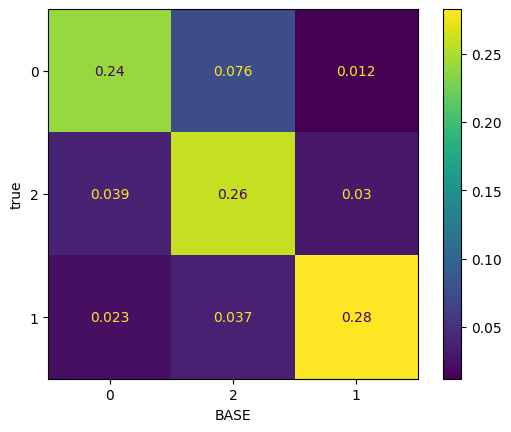

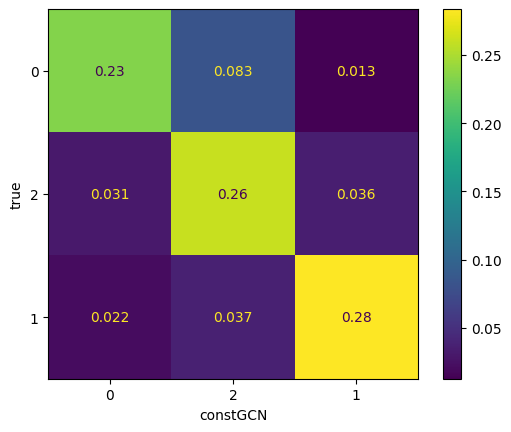

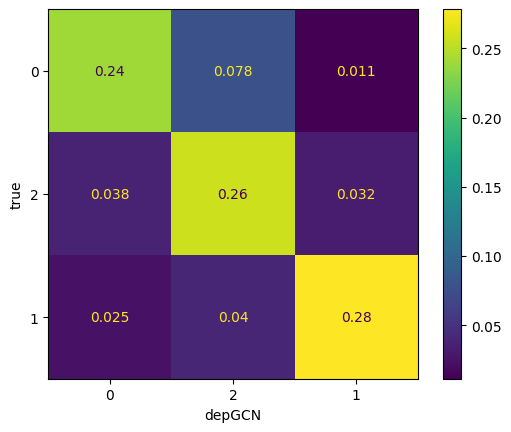

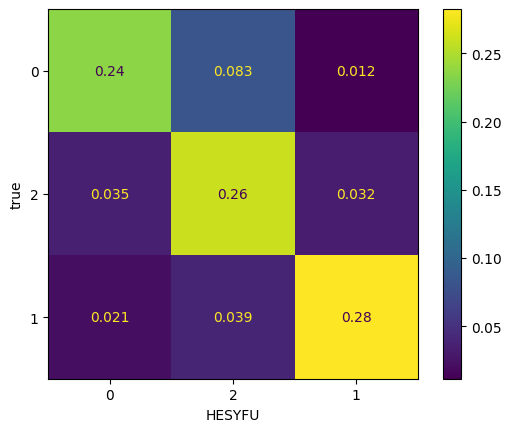

2139
2186
2188
2186


In [ ]:

# BASE
y_true = true_snli_test #true label
y_base = get_pickled_predictions('base_preds_snli_test.pickle') #predicted label
y_constGCN = get_pickled_predictions('constGCN_preds_snli_test.pickle') #predicted label
y_depGCN = get_pickled_predictions('depGCN_preds_snli_test.pickle') #predicted label
y_hesyfu = get_pickled_predictions('cahesyfu_preds_snli_test.pickle') #predicted label


bool_arr0 = np.array(y_true) != np.array(y_base)
bool_arr1 = np.array(y_true) != np.array(y_constGCN)
bool_arr2 = np.array(y_true) != np.array(y_depGCN)
bool_arr3 = np.array(y_true) != np.array(y_hesyfu)



# plot_confusion_matrix(np.array(y_true)[bool_arr0], np.array(y_base)[bool_arr0], 'true', 'BASE' )
# # constGCN
# plot_confusion_matrix(np.array(y_true)[bool_arr1], np.array(y_constGCN)[bool_arr1], 'true','constGCN')
# # depGCN
# plot_confusion_matrix(np.array(y_true)[bool_arr2], np.array(y_depGCN)[bool_arr2], 'true','depGCN')
# # HESYFU
# plot_confusion_matrix(np.array(y_true)[bool_arr3], np.array(y_hesyfu)[bool_arr3], 'true','HESYFU')


plot_confusion_matrix(y_true, y_base, 'true', 'BASE' )
# constGCN
plot_confusion_matrix(y_true, y_constGCN, 'true','constGCN')
# depGCN
plot_confusion_matrix(y_true, y_depGCN, 'true','depGCN')
# HESYFU
plot_confusion_matrix(y_true, y_hesyfu, 'true','HESYFU')

print(bool_arr0.sum())
print(bool_arr1.sum())
print(bool_arr2.sum())
print(bool_arr3.sum())

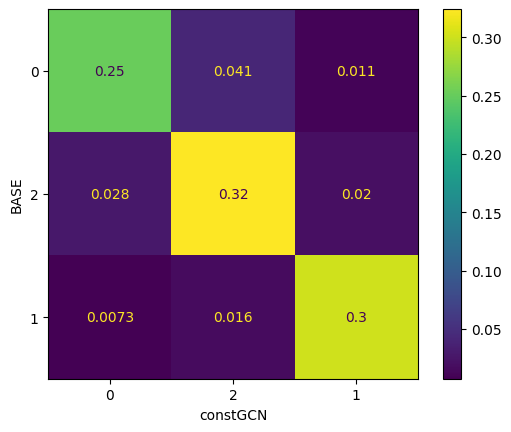

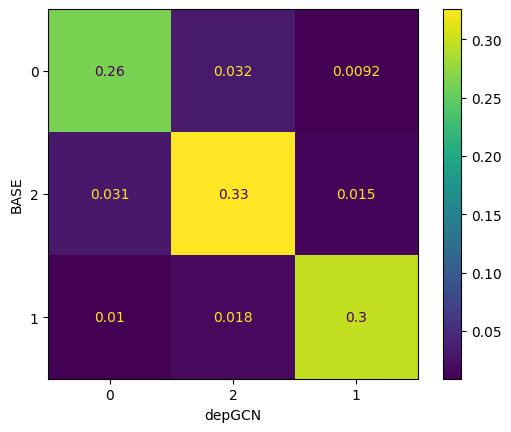

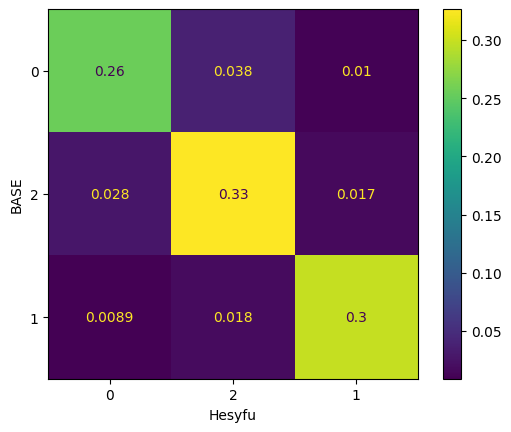

In [ ]:

# BASE
# y_true = true_snli_test #true label
y_base = get_pickled_predictions('base_preds_snli_test.pickle') #predicted label
y_constGCN = get_pickled_predictions('constGCN_preds_snli_test.pickle')
y_depGCN = get_pickled_predictions('depGCN_preds_snli_test.pickle') #predicted label
y_hesyfu = get_pickled_predictions('cahesyfu_preds_snli_test.pickle') #predicted label



plot_confusion_matrix(y_base, y_constGCN, 'BASE', 'constGCN' )

# constGCN
plot_confusion_matrix(y_base, y_depGCN, 'BASE','depGCN')

# depGCN
plot_confusion_matrix(y_base, y_hesyfu, 'BASE','Hesyfu')




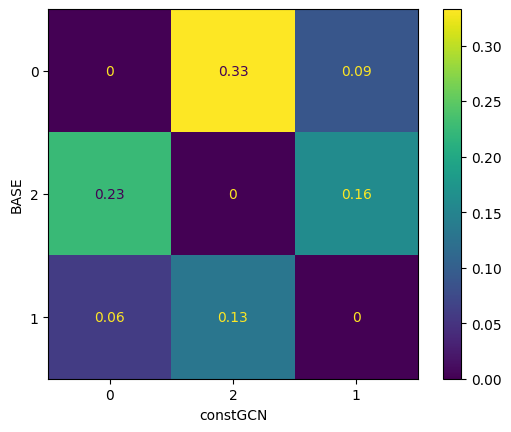

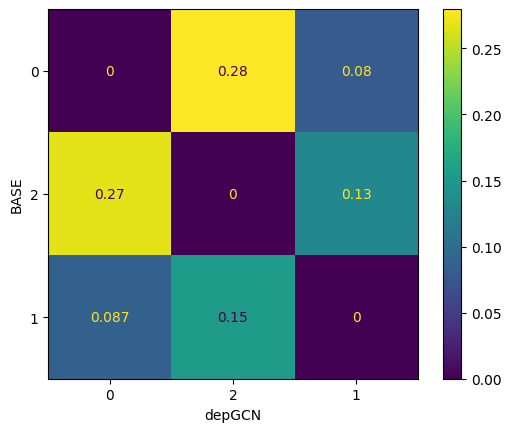

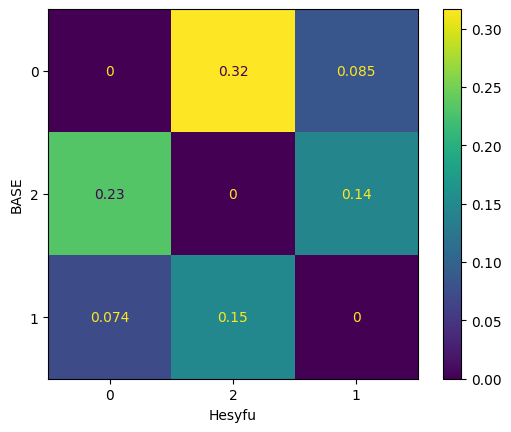

1205
1126
1174


In [ ]:
bool_arr1 = np.array(y_base) != np.array(y_constGCN)
bool_arr2 = np.array(y_base) != np.array(y_depGCN)
bool_arr3 = np.array(y_base) != np.array(y_hesyfu)


plot_confusion_matrix(np.array(y_base)[bool_arr1], np.array(y_constGCN)[bool_arr1], 'BASE', 'constGCN' )

# constGCN
plot_confusion_matrix(np.array(y_base)[bool_arr2], np.array(y_depGCN)[bool_arr2], 'BASE','depGCN')

# depGCN
plot_confusion_matrix(np.array(y_base)[bool_arr3], np.array(y_hesyfu)[bool_arr3], 'BASE','Hesyfu')
print(bool_arr1.sum())
print(bool_arr2.sum())
print(bool_arr3.sum())

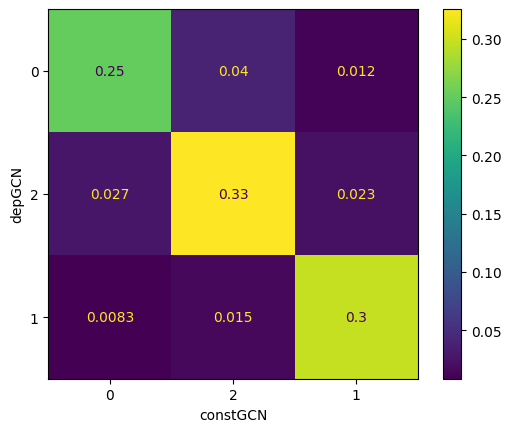

In [ ]:
plot_confusion_matrix(y_depGCN, y_constGCN, 'depGCN', 'constGCN' )





# Section 5A: Constituency Analysis: Tree similarities

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
def plot_tree_similarity(data, labels, title, dataset):
    # Concatenate the data columns into a single DataFrame
    combined_data = pd.concat(data, axis=1)

    # Create a line plot of the frequency distributions
    for i, data_col in enumerate(data):
        sns.distplot(data_col, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label = labels[i])
    # Set the range for x-axis
    plt.xlim(combined_data.min().min(), 1)

    # Set the axis labels and title
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(title)

    # Add a legend
    plt.legend()
    plt.savefig(title+'.pdf', format='pdf')

    # Show the plot
    plt.show()

    # Print mean values for each data column
    for i, data_col in enumerate(data):
        print(f"{labels[i]} Mean Tree Distance: {data_col.mean():.2f}")


## by Model by correct/incorrect

In [ ]:
# MNLI, FeverNLI, ANLI, LingNLI, WaNLI
from zipfile import ZipFile
file_name = "MNLI_train.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()

file_name = "fever_train.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()
file_name = "anli_train.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()
file_name = "lingNLI_train.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()
file_name = "waNLI_train.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()

File Name                                             Modified             Size
MNLI_train.pickle                              2023-05-10 10:41:18    408470578
File Name                                             Modified             Size
fever_train.pickle                             2023-06-04 16:23:56    394408454
File Name                                             Modified             Size
anli_train.pickle                              2023-06-04 20:44:48    354491804
File Name                                             Modified             Size
lingNLI_train.pickle                           2023-05-31 10:27:28     63337733
File Name                                             Modified             Size
waNLI_train.pickle                             2023-05-31 11:22:02    130241653


0.3139084848938767


<ipython-input-7-a00adde4a6fe>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_col, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label = labels[i])
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-7-a00adde4a6fe>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (

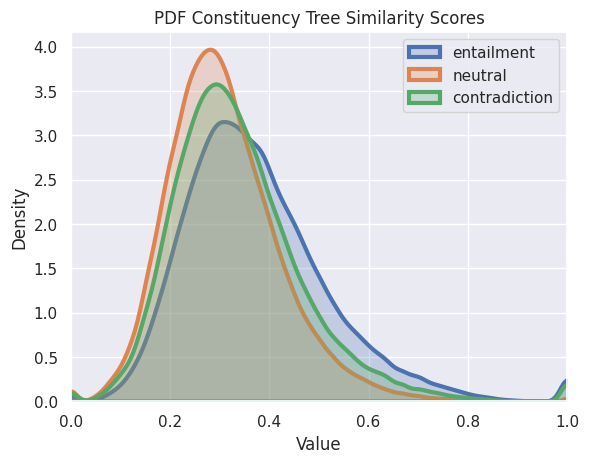

entailment Mean Tree Distance: 0.37
neutral Mean Tree Distance: 0.31
contradiction Mean Tree Distance: 0.34


In [ ]:
df1=pd.read_pickle('MNLI_train.pickle')
df2=pd.read_pickle('fever_train.pickle')
df3=pd.read_pickle('anli_train.pickle')
df4=pd.read_pickle('lingNLI_train.pickle')
df5=pd.read_pickle('waNLI_train.pickle')

train_data= pd.concat([df1, df2, df3,df4, df5], axis=0, ignore_index=True)
#join text_sentence1 and text_sentence2 to check duplicates
train_data['sentence12'] = train_data.apply(lambda row: ' '.join(row['text_sentence1'] + row['text_sentence2']), axis=1)
#drop duplicates
train_data = train_data.drop_duplicates(subset=['sentence12'], keep='last')
train_data['distances'] = calculate_const_tree_similarity(train_data)
avg_distance = train_data['distances'].mean()
print(avg_distance)
#1=neutral, 0=entailment, 2=contr
#entailment label
e = train_data[train_data['gold_label']==0]['distances']
#neutral label
n = train_data[train_data['gold_label']==1]['distances']
#contradiction label
c = train_data[train_data['gold_label']==2]['distances']

tree_distances=[e, n,c]
labels=['entailment', 'neutral','contradiction']
plot_tree_similarity(tree_distances, labels, "PDF Constituency Tree Similarity Scores", "MFALW")

In [ ]:
df1=read_dropna_encode_dataframe('MNLI_train.pickle',le,False, is_mnli=True)
df2=read_dropna_encode_dataframe('fever_train.pickle',le,False)
df3=read_dropna_encode_dataframe('anli_train.pickle',le,False)
df4=read_dropna_encode_dataframe('lingNLI_train.pickle',le,False)
df5=read_dropna_encode_dataframe('waNLI_train.pickle',le,False)

train_data= pd.concat([df1, df2, df3,df4, df5], axis=0, ignore_index=True)
#join text_sentence1 and text_sentence2 to check duplicates
train_data['sentence12'] = train_data.apply(lambda row: ' '.join(row['text_sentence1'] + row['text_sentence2']), axis=1)
#drop duplicates
train_data = train_data.drop_duplicates(subset=['sentence12'], keep='last')
train_data['distances'] = calculate_const_tree_similarity(train_data)
avg_distance = train_data['distances'].mean()
print(avg_distance)
#1=neutral, 0=entailment, 2=contr
#entailment label
e = train_data[train_data['gold_label']==0]['distances']
#neutral label
n = train_data[train_data['gold_label']==1]['distances']
#contradiction label
c = train_data[train_data['gold_label']==2]['distances']

tree_distances=[e, n,c]
labels=['entailment', 'neutral','contradiction']
plot_tree_similarity(tree_distances, labels, "PDF Constituency Tree Similarity Scores", "MFALW")

Exception ignored in: <function _xla_gc_callback at 0x7f6be9b31bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: ignored

In [ ]:
#SNLI test
df = pd.read_pickle('SNLI_test.pickle')
df= df[df['gold_label']!='-']
similarities = calculate_const_tree_similarity(df)

model_name = 'constGCN'
dataset = 'snli_test'

y_true = true_snli_test #true label
preds = get_pickled_predictions(model_name+'_preds_'+dataset+'.pickle') #predicted label
df['preds'] = preds
df['true']=y_true
df['tree_similarity'] = similarities

correct_mean_tree_distance= df[df['preds'] == df['true']]['tree_similarity']
incorrect_mean_tree_distance=df[df['preds'] != df['true']]['tree_similarity']


tree_distances=[correct_mean_tree_distance, incorrect_mean_tree_distance]
labels=['correct', 'incorrect']
plot_tree_similarity(tree_distances, labels, model_name, dataset)


KeyboardInterrupt: ignored

In [ ]:
file_name = "HANS_MED_original.zip"
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

In [ ]:
#HANS
df= pd.read_pickle('HANS_val.pickle')
df['tree_similarity'] = calculate_const_tree_similarity(hans)
df['heuristic']=pd.read_pickle('HANS_val_original.pickle')['heuristic']

model_name = 'base'
dataset = 'hans'

y_true = true_hans #true label
preds = get_pickled_predictions(model_name+'_preds_'+dataset+'.pickle') #predicted label
df['preds'] = preds
df['true']=y_true

correct_mean_tree_distance= df[df['preds'] == df['true']]['tree_similarity']
incorrect_mean_tree_distance=df[df['preds'] != df['true']]['tree_similarity']

tree_distances=[correct_mean_tree_distance, incorrect_mean_tree_distance]
labels=['correct', 'incorrect']
plot_tree_similarity(tree_distances, labels, model_name, dataset)


### By model by label

In [ ]:
df = pd.read_pickle('SNLI_test.pickle')
df= df[df['gold_label']!='-']
y_true = true_snli_test #true label

model_name = 'constGCN'
dataset = 'snli_test'

df['preds'] = get_pickled_predictions(model_name+'_preds_'+dataset+'.pickle')
df['true']=y_true
df['tree_distance'] = similarities



e = df[df['preds']==1]['tree_distance']

#neutral label
n = df[df['preds']==2]['tree_distance']

#contradiction label
c = df[df['preds']==0]['tree_distance']

tree_distances=[e, n,c]
labels=['entailment', 'neutral','contradiction']
plot_tree_similarity(tree_distances, labels, model_name, dataset)

## By Dataset

In [ ]:
#SNLI
from zipfile import ZipFile
# specifying the zip file name
file_name = "SNLI_2validations.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()

# MNLI

In [ ]:
from zipfile import ZipFile
# specifying the zip file name
file_name = "MNLI_train.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()

File Name                                             Modified             Size
MNLI_train.pickle                              2023-05-10 10:41:18    408470578


In [ ]:
mnli_train

0.3396001487276934


<ipython-input-53-a00adde4a6fe>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_col, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label = labels[i])
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-53-a00adde4a6fe>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot`

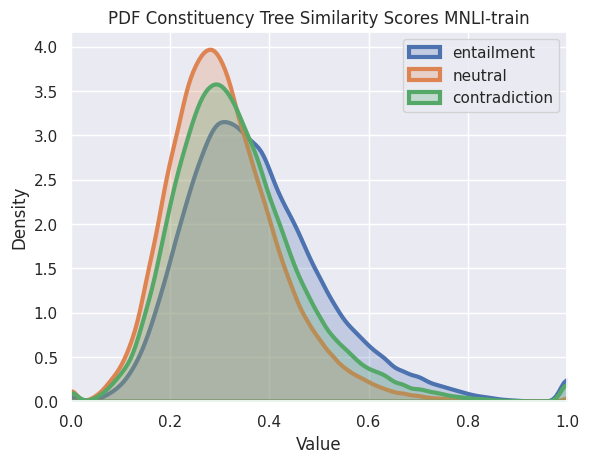

entailment Mean Tree Distance: 0.37
neutral Mean Tree Distance: 0.31
contradiction Mean Tree Distance: 0.34


In [ ]:
# mnli_train = pd.read_pickle('MNLI_train.pickle')
# mnli_train['distances'] = calculate_const_tree_similarity(mnli_train)
avg_distance = mnli_train['distances'].mean()
print(avg_distance)
#1=neutral, 0=entailment, 2=contr
#entailment label
e = mnli_train[mnli_train['gold_label']==0]['distances']
#neutral label
n = mnli_train[mnli_train['gold_label']==1]['distances']
#contradiction label
c = mnli_train[mnli_train['gold_label']==2]['distances']

tree_distances=[e, n,c]
labels=['entailment', 'neutral','contradiction']
plot_tree_similarity(tree_distances, labels, "PDF Constituency Tree Similarity Scores MNLI-train", "MNLI_train")

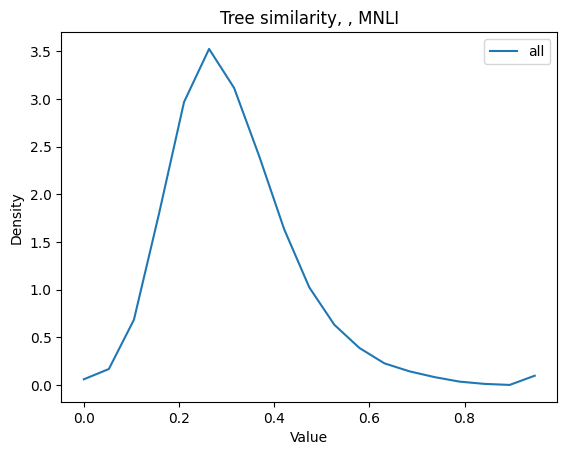

all Mean Tree Distance: 0.34


In [ ]:
# all labels
tree_distances=[mnli_train['distances']]
labels=['all']
plot_tree_similarity(tree_distances, labels,'', 'MNLI')

#SNLI

<ipython-input-53-a00adde4a6fe>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_col, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label = labels[i])
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-53-a00adde4a6fe>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot`

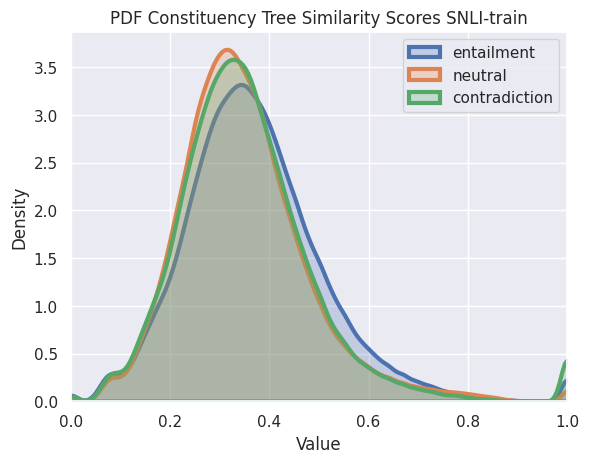

entailment Mean Tree Distance: 0.37
neutral Mean Tree Distance: 0.35
contradiction Mean Tree Distance: 0.35


In [ ]:
snli_train = pd.read_pickle('SNLI_train.pickle')
snli_train['distances'] = calculate_const_tree_similarity(snli_train)
avg_distance = snli_train['distances'].mean()

#entailment label
e = snli_train[snli_train['gold_label']=='entailment']['distances']
#neutral label
n = snli_train[snli_train['gold_label']=='neutral']['distances']
#contradiction label
c = snli_train[snli_train['gold_label']=='contradiction']['distances']

tree_distances=[e, n,c]
labels=['entailment', 'neutral','contradiction']
plot_tree_similarity(tree_distances, labels, "PDF Constituency Tree Similarity Scores SNLI-train", "SNLI_train")


<ipython-input-53-a00adde4a6fe>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_col, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label = labels[i])
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


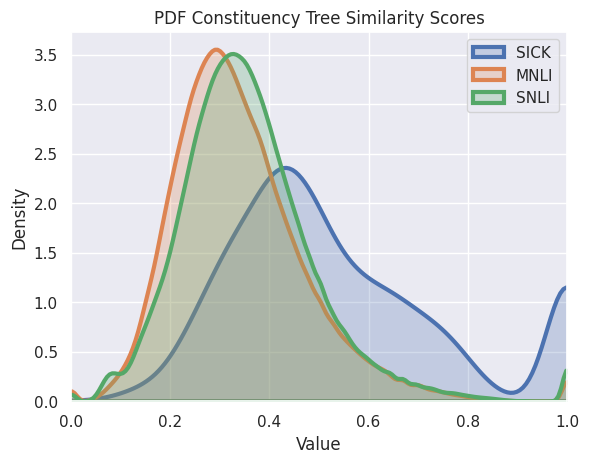

SICK Mean Tree Distance: 0.54
MNLI Mean Tree Distance: 0.34
SNLI Mean Tree Distance: 0.36


In [ ]:
# all labels
tree_distances=[sick['distances'], mnli_train['distances'],snli_train['distances']]
labels=['SICK', 'MNLI', 'SNLI']
plot_tree_similarity(tree_distances, labels,'PDF Constituency Tree Similarity Scores',"")


# noHOB


In [ ]:
# snli_train = pd.read_pickle('SNLI_train_noHOB.pickle')
# snli_train['distances'] = calculate_const_tree_similarity(snli_train)
# avg_distance = snli_train['distances'].mean()

#entailment label
# e = snli_train[snli_train['gold_label']==[0,1,0]]['distances']
# #neutral label
# n = snli_train[snli_train['gold_label']==[0,0,1]]['distances']
# #contradiction label
# c = snli_train[snli_train['gold_label']==[1,0,0]]['distances']

contr, ent, neutr = [1, 0, 0],[0, 1, 0],[0, 0, 1]

filtered_e = snli_train[snli_train['gold_label'].apply(lambda x: x == ent)]
filtered_e = filtered_e['distances']

filtered_c = snli_train[snli_train['gold_label'].apply(lambda x: x == contr)]
filtered_c = filtered_c['distances']

filtered_n = snli_train[snli_train['gold_label'].apply(lambda x: x == neutr)]
filtered_n = filtered_n['distances']


tree_distances=[filtered_e, filtered_n,filtered_c]
labels=['entailment', 'neutral','contradiction']
plot_tree_similarity(tree_distances, labels, "", "SNLI_noHOB")


In [ ]:
#SNLI + HELP
# snli_train = pd.read_pickle('SNLI_train.pickle')
# help= pd.read_pickle('HELP_train.pickle')
# Reset the index

# combined = pd.concat([snli_train, help], axis=0)

combined = combined.reset_index(drop=True)
# combined['distances'] = calculate_const_tree_similarity(combined)


#entailment label
e=combined[combined['gold_label']=='entailment']['distances']
#neutral label
n=combined[combined['gold_label']=='neutral']['distances']
#contradiction label
c=combined[combined['gold_label']=='contradiction']['distances']

tree_distances=[e, n,c]
labels=['entailment', 'neutral','contradiction']
plot_tree_similarity(tree_distances, labels, "", "SNLI_train+HELP")


In [ ]:
combined.columns

In [ ]:
from zipfile import ZipFile
# specifying the zip file name
file_name = "SICK.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()

File Name                                             Modified             Size
sick_test.pickle                               2023-02-27 19:16:34      3835803
sick_train.pickle                              2023-02-27 19:14:30      3511522
sick_val.pickle                                2023-03-15 09:53:24       408270


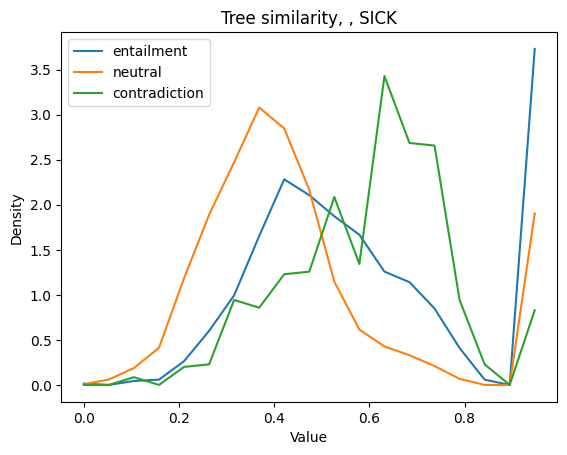

entailment Mean Tree Distance: 0.62
neutral Mean Tree Distance: 0.47
contradiction Mean Tree Distance: 0.63


In [ ]:
# SICK
sick= pd.read_pickle('sick_train.pickle')
sick['distances'] = calculate_const_tree_similarity(sick)
avg_distance = sick['distances'].mean()
#entailment label
e=sick[sick['gold_label']=='entailment']['distances']
#neutral label
n=sick[sick['gold_label']=='neutral']['distances']
#contradiction label
c=sick[sick['gold_label']=='contradiction']['distances']

tree_distances=[e, n,c]
labels=['entailment', 'neutral','contradiction']
plot_tree_similarity(tree_distances, labels, '', 'SICK')

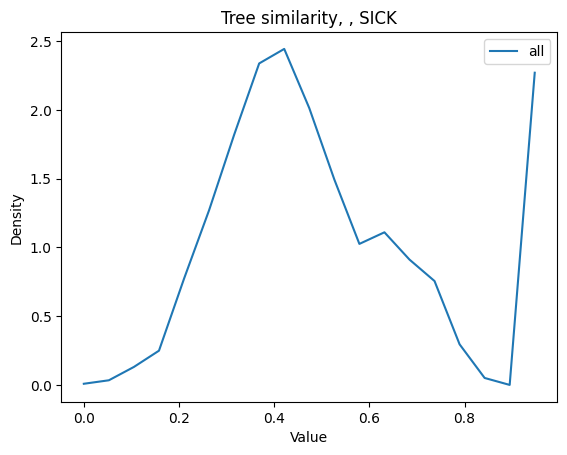

all Mean Tree Distance: 0.54


In [ ]:
# all labels
tree_distances=[sick['distances']]
labels=['all']
plot_tree_similarity(tree_distances, labels,'', 'SICK')

In [ ]:
# SICK, merge contradiction and neutral
sick= pd.read_pickle('sick_train.pickle')
sick['distances'] = calculate_const_tree_similarity(sick)
avg_distance = sick['distances'].mean()
#entailment label
e=sick[sick['gold_label']=='entailment']['distances']
#neutral label
n=sick[sick['gold_label']!='entailment']['distances']


tree_distances=[e, n]
labels=['entailment', 'neutral']
plot_tree_similarity(tree_distances, labels, "", "SICK_train")

In [ ]:
#HELP
help= pd.read_pickle('HELP_train.pickle')
help['distances'] = calculate_const_tree_similarity(help)
avg_distance = help['distances'].mean()
#entailment label
e=help[help['gold_label']=='entailment']['distances']
#neutral label
n=help[help['gold_label']=='neutral']['distances']

tree_distances=[e, n]
labels=['entailment', 'neutral']
plot_tree_similarity(tree_distances, labels, model_name, dataset)

In [ ]:
#MED
med= pd.read_pickle('MED_val.pickle')
med['distances'] = calculate_const_tree_similarity(med)

#entailment label
e=med[med['gold_label']=='entailment']['distances']
#neutral label
n=med[med['gold_label']=='neutral']['distances']

tree_distances=[e, n]
labels=['entailment', 'neutral']
plot_tree_similarity(tree_distances, labels, "", 'MED')

In [ ]:
#HANS
# hans= pd.read_pickle('HANS_val.pickle')
# hans['distances'] = calculate_const_tree_similarity(hans)
hans['heuristic']=pd.read_pickle('HANS_val_original.pickle')['heuristic']
avg_distance = hans['distances']
#entailment label
e=hans[hans['gold_label']==0]['distances']
#neutral label
n=hans[hans['gold_label']==1]['distances']

lex = hans[hans['heuristic']=='lexical_overlap']['distances']
subseq = hans[hans['heuristic']=='subsequence']['distances']
const = hans[hans['heuristic']=='constituent']['distances']

#by label
# tree_distances=[e, n]
# labels=['entailment', 'neutral']
# plot_tree_similarity(tree_distances, labels, model_name, dataset)

#by heuristic
# tree_distances=[lex,subseq,const]
# labels=['lex', 'subseq','const']
# plot_tree_similarity(tree_distances, labels, model_name, dataset)

#both
tree_distances=[e,n,lex,subseq,const]
labels=['entailment','neutral','lex', 'subseq','const']
plot_tree_similarity(tree_distances, labels, model_name, dataset)


## SNLI-train constituency unigrams

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer


df= pd.read_pickle('SNLI_train.pickle')
df = df[df['gold_label']=='entailment']
c_dict= {'(':0, ')':0, 'ROOT':0,'NP': 0, 'DT': 1, 'NN': 2, 'PP': 3, 'IN': 4, 'S': 5, 'VP': 6, 'VBZ': 7, 'ADJP': 8, 'VBN': 9, 'RP': 10, '.': 11, 'VBG': 12, 'PRP$': 13, ',': 14, 'ADVP': 15, 'RB': 16, 'NNS': 17, 'CC': 18, 'PRP': 19, 'VBP': 20, 'EX': 21, 'JJ': 22, 'JJR': 23, 'SBAR': 24, 'TO': 25, 'VB': 26, 'CD': 27, 'HYPH': 28, 'WHNP': 29, 'WP': 30, 'VBD': 31, 'PRT': 32, 'NML': 33, 'NNP': 34, 'WHADVP': 35, 'WRB': 36, 'WDT': 37, 'POS': 38, 'QP': 39, 'WHADJP': 40, 'MD': 41, '``': 42, 'NNPS': 43, "''": 44, 'PDT': 45, 'RBR': 46, 'JJS': 47, 'UH': 48, 'UCP': 49, 'WHPP': 50, 'AFX': 51, 'SYM': 52, 'SINV': 53, 'X': 54, 'CONJP': 55, 'NFP': 56, 'FRAG': 57, 'WP$': 58, ':': 59, '-LRB-': 60, '-RRB-': 61, 'SBARQ': 62, 'SQ': 63, 'FW': 64, 'PRN': 65, 'INTJ': 66, 'RBS': 67, '$': 68, 'ADD': 69, 'RRC': 70, 'LST': 71, 'LS': 72, 'GW': 73}
def replace_words_not_in_dict(tree_str, c_dict):
    words_to_replace =re.findall(r"[\w']+|\(|\)", tree_str)
    # replace each word with 'x'
    for word in words_to_replace:
        if word not in c_dict:
            tree_str = tree_str.replace(word, 'x')
    return tree_str
df['sentence1_parse'] = df['sentence1_parse'].apply(lambda x: replace_words_not_in_dict(x, c_dict))
df['sentence2_parse'] = df['sentence2_parse'].apply(lambda x: replace_words_not_in_dict(x, c_dict))
# Function to check if one dictionary is fully contained within another dictionary
def is_fully_contained(d1, d2):
    for key, value in d1.items():
        if key not in d2 or d2[key] < value:
            return False
    return True

# Function to check if unigram features of one column are fully contained within another column
def check_unigrams(row):
    unigrams1 = row['unigrams1']
    unigrams2 = row['unigrams2']
    return is_fully_contained(unigrams1, unigrams2) or is_fully_contained(unigrams2, unigrams1)

# Process data in chunks
chunksize = 10000  # Adjust this value based on your memory constraints
vectorizer = CountVectorizer()
total_count = 0

# Iterate through the DataFrame in chunks
for i in range(0, len(df), chunksize):
    chunk = df[i:i + chunksize]
    print(f'Processing chunk {i // chunksize + 1}')

    # Tokenize the strings into unigrams
    unigrams1 = vectorizer.fit_transform(chunk['sentence1_parse'])
    unigrams2 = vectorizer.fit_transform(chunk['sentence2_parse'])

    # Add unigram dictionaries to the chunk
    chunk['unigrams1'] = [dict(zip(vectorizer.get_feature_names_out(), row)) for row in unigrams1.toarray()]
    chunk['unigrams2'] = [dict(zip(vectorizer.get_feature_names_out(), row)) for row in unigrams2.toarray()]

    # Apply the check_unigrams function to the chunk
    chunk['unigrams_fully_contained'] = chunk.apply(check_unigrams, axis=1)

    # Count the number of cases with fully contained unigrams
    total_count += chunk['unigrams_fully_contained'].sum()
    print(chunk['unigrams_fully_contained'].sum())
print(f'Total number of cases with fully contained unigrams: {total_count}')
print(f'Proportion of cases with fully contained unigrams: {total_count/len(df)}')


# Section 5B: Dependency Analysis

In [ ]:
#SNLI
from zipfile import ZipFile
# specifying the zip file name
file_name = "SNLI_2validations.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()

## By dataset

In [ ]:
snli_train = pd.read_pickle('SNLI_train.pickle')
snli_train['similarity'] = snli_train.apply(calculate_dep_tree_similarity, axis=1)

#entailment label
e = snli_train[snli_train['gold_label']=='entailment']['similarity']
#neutral label
n = snli_train[snli_train['gold_label']=='neutral']['similarity']
#contradiction label
c = snli_train[snli_train['gold_label']=='contradiction']['similarity']

tree_distances=[e,n,c]
labels=['entailment','neutral','contradiction']
plot_tree_similarity(tree_distances, labels, model_name, dataset)


In [ ]:
# SICK
sick= pd.read_pickle('sick_train.pickle')
sick['similarity'] = sick.apply(calculate_dep_tree_similarity, axis=1)
avg_distance = sick['similarity'].mean()
#entailment label
e=sick[sick['gold_label']=='entailment']['similarity']
#neutral label
n=sick[sick['gold_label']=='neutral']['similarity']
#contradiction label
c=sick[sick['gold_label']=='contradiction']['similarity']


tree_distances=[e,n,c]
labels=['entailment','neutral','contradiction']
plot_tree_similarity(tree_distances, labels, model_name, dataset)


In [ ]:
#merge ent and neutr
avg_distance = sick['similarity'].mean()
#entailment label
e=sick[sick['gold_label']=='entailment']['similarity']
#neutral label
n=sick[sick['gold_label']!='entailment']['similarity']

tree_distances=[e,n]
labels=['entailment','neutral']
plot_tree_similarity(tree_distances, labels, model_name, dataset)

In [ ]:
#HELP
help= pd.read_pickle('HELP_train.pickle')
help['similarity'] = help.apply(calculate_dep_tree_similarity, axis=1)
avg_distance = help['similarity'].mean()
#entailment label
e=help[help['gold_label']=='entailment']['similarity']
#neutral label
n=help[help['gold_label']=='neutral']['similarity']

tree_distances=[e,n]
labels=['entailment','neutral']
plot_tree_similarity(tree_distances, labels, model_name, dataset)

In [ ]:
#SNLI + HELP
snli_train = pd.read_pickle('SNLI_train.pickle')
help= pd.read_pickle('HELP_train.pickle')
# Reset the index

combined = pd.concat([snli_train, help], axis=0)

combined = combined.reset_index(drop=True)
combined['distances'] =  combined.apply(calculate_dep_tree_similarity, axis=1)

#entailment label
e=combined[combined['gold_label']=='entailment']['distances']
#neutral label
n=combined[combined['gold_label']=='neutral']['distances']
#contradiction label
c=combined[combined['gold_label']=='contradiction']['distances']

tree_distances=[e, n,c]
labels=['entailment', 'neutral','contradiction']
plot_tree_similarity(tree_distances, labels, "", "SNLI_train+HELP")


In [ ]:




#MED
med= pd.read_pickle('MED_val.pickle')
med['distances'] = med.apply(calculate_dep_tree_similarity, axis=1)
#entailment label
e=med[med['gold_label']=='entailment']['distances']
#neutral label
n=med[med['gold_label']=='neutral']['distances']

tree_distances=[e, n]
labels=['entailment', 'neutral']
plot_tree_similarity(tree_distances, labels, "", 'MED')

In [ ]:
#HANS
# hans= pd.read_pickle('HANS_val.pickle')
# hans['similarity'] = hans.apply(calculate_dep_tree_similarity, axis=1)
hans['heuristic']=pd.read_pickle('HANS_val_original.pickle')['heuristic']
avg_distance = hans['similarity']
#entailment label
e=hans[hans['gold_label']==0]['similarity']
#neutral label
n=hans[hans['gold_label']==1]['similarity']

lex = hans[hans['heuristic']=='lexical_overlap']['similarity']
subseq = hans[hans['heuristic']=='subsequence']['similarity']
const = hans[hans['heuristic']=='constituent']['similarity']

# by label
# tree_distances=[e,n]
# labels=['entailment','neutral']
# plot_tree_similarity(tree_distances, labels, model_name, dataset)

# #by heuristic
tree_distances=[lex,subseq,const]
labels=['lex','subseq','const']
plot_tree_similarity(tree_distances, labels, model_name, dataset)

#both
# tree_distances=[e,n, lex,subseq,const]
# labels=['entailment','neutral', 'lex','subseq','const']
# plot_tree_similarity(tree_distances, labels, model_name, dataset)


## By model

In [ ]:
df = pd.read_pickle('SNLI_test.pickle')
df= df[df['gold_label']!='-']
df['tree_similarity'] = df.apply(calculate_dep_tree_similarity, axis=1)

model_name = 'cahesyfu'
dataset = 'snli_test'

y_true = true_snli_test #true label
preds = get_pickled_predictions(model_name+'_preds_'+dataset+'.pickle') #predicted label
df['preds'] = preds
df['true']=y_true


correct_mean_tree_distance= df[df['preds'] == df['true']]['tree_similarity']
incorrect_mean_tree_distance=df[df['preds'] != df['true']]['tree_similarity']

tree_distances=[correct_mean_tree_distance,incorrect_mean_tree_distance]
labels=['correct predictions','incorrect predictions']
plot_tree_similarity(tree_distances, labels, model_name, dataset)


In [ ]:
#HANS
df= pd.read_pickle('HANS_val.pickle')
df['tree_similarity'] = df.apply(calculate_dep_tree_similarity, axis=1)
df['heuristic']=pd.read_pickle('HANS_val_original.pickle')['heuristic']

model_name = 'depGCN'
dataset = 'hans'

y_true = true_hans #true label
preds = get_pickled_predictions(model_name+'_preds_'+dataset+'.pickle') #predicted label
df['preds'] = preds
df['true']=y_true

correct_mean_tree_distance= df[df['preds'] == df['true']]['tree_similarity']
incorrect_mean_tree_distance=df[df['preds'] != df['true']]['tree_similarity']

tree_distances=[correct_mean_tree_distance,incorrect_mean_tree_distance]
labels=['correct predictions','incorrect predictions']
plot_tree_similarity(tree_distances, labels, model_name, dataset)

# Section 6: SNLI 5-annotator label analysis

In [ ]:
!wget https://nlp.stanford.edu/projects/snli/snli_1.0.zip
import pandas as pd
from zipfile import ZipFile
# specifying the zip file name
file_name = "snli_1.0.zip"
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')
df_test_original = pd.read_csv('snli_1.0/snli_1.0_test.txt', sep='\t', on_bad_lines='skip')#1
df_test_original=df_test_original[df_test_original.gold_label!='-']
#df_test_original=df_test_original.dropna()#3

In [ ]:
#for training set
df_train = pd.read_csv('snli_1.0/snli_1.0_train.txt', sep='\t', on_bad_lines='skip')#1
df_train = df_train.dropna(subset=['label2', 'label3','label4','label5'])
# df=df_train[df_train['gold_label'] == 'contradiction']
df=df_train

In [ ]:
df.sample(n=5)

In [ ]:
#get sentence lengths
df=df_train
df=df.dropna()
import pandas as pd
df=df[df['gold_label'] == 'neutral']
# Split sentences into list of words using loc
df.loc[:, 'column1_word_list'] = df['sentence1'].str.split()
df.loc[:, 'column2_word_list'] = df['sentence2'].str.split()

# Calculate length of each list and take mean
column1_avg_length = df['column1_word_list'].apply(len).median()
column2_avg_length = df['column2_word_list'].apply(len).median()

print("median sentence length of sentence 1: ", column1_avg_length)
print("median sentence length of sentence2 2: ", column2_avg_length)


In [ ]:
# df_5annotator = agreement rate of the 5 annotators for the gold label
df_5annotator = df[['label1','label2','label3','label4','label5']]
df_5annotator=df_5annotator.apply(pd.Series.value_counts, axis=1)
df_5annotator=df_5annotator[["contradiction", "entailment", "neutral"]].max(axis=1)
# df_5annotator = df_5annotator/5
df_5annotator

In [ ]:
df_train['annotator_agreement']=df_5annotator


In [ ]:
df=df_train[df_train['gold_label'] == 'entailment']
df['annotator_agreement'].mean()

In [ ]:
# df_5annotator = agreement rate of the 5 annotators for the gold label
df_5annotator = df[['label1','label2','label3','label4','label5']]
df_5annotator=df_5annotator.apply(pd.Series.value_counts, axis=1)
# df_5annotator=df_5annotator[["contradiction", "entailment", "neutral"]].max(axis=1)
# df_5annotator = df_5annotator/5
df_5annotator


In [ ]:
#given a df and modelname, find out agreement rate of 5 annotators
def calc_agreement_rates(df, model_name,preds,true):

  agreement_rates=df[["contradiction", "entailment", "neutral"]].max(axis=1)
  df['agreement_rate'] = agreement_rates
  df['preds']=preds
  df['true_label']=true
  #split correct vs incorrect
  correct = df[df['preds'] == df['true_label']]
  incorrect = df[df['preds'] != df['true_label']]

  #average the agreement rates
  correct_agreement_rate = correct['agreement_rate'].mean()
  incorrect_agreement_rate =incorrect['agreement_rate'].mean()

  correct_cases_agreement_counts = correct.groupby('agreement_rate').count()['true_label'].to_list()
  incorrect_cases_agreement_counts = incorrect.groupby('agreement_rate').count()['true_label'].to_list()

  results = [model_name, correct_agreement_rate, incorrect_agreement_rate]
  results.append( correct_cases_agreement_counts)
  results.append(incorrect_cases_agreement_counts)
  results.append([round(x/len(correct)*100,4) for x in correct_cases_agreement_counts])
  results.append([round(x/len(incorrect)*100,4) for x in incorrect_cases_agreement_counts])


  return results

#given a df and modelname, make histogram of agreements
def make_hist_5annotators(df,model):
  agreement_rates=df[["contradiction", "entailment", "neutral"]].max(axis=1)
  df['agreement_rate'] = agreement_rates
  #split correct vs incorrect
  correct = df[df[model] == df['true_label']]
  incorrect = df[df[model] != df['true_label']]

  #average the agreement rates
  # df_annotators_histogram = pd.DataFrame([correct['agreement_rate'].to_list(),incorrect['agreement_rate'].to_list() ]).hist(bins=3)
  correct_hist = correct['agreement_rate'].hist(bins=3)
  incorrect_hist =incorrect['agreement_rate'].hist(bins=3)

  return correct_hist,incorrect_hist


In [ ]:
base_5annotator_results = calc_agreement_rates(df_5annotator,'base', get_pickled_predictions('base_preds_snli_test.pickle'), true_snli_test)
constGCN_5annotator_results = calc_agreement_rates(df_5annotator,'constGCN', get_pickled_predictions('constGCN_preds_snli_test.pickle'), true_snli_test)
depGCN_5annotator_results = calc_agreement_rates(df_5annotator,'depGCN', get_pickled_predictions('depGCN_preds_snli_test.pickle'), true_snli_test)
cahesyfu_5annotator_results = calc_agreement_rates(df_5annotator, 'cahesyfu', get_pickled_predictions('cahesyfu_preds_snli_test.pickle'), true_snli_test)

from tabulate import tabulate

rows= [['Model', 'correct cases\n avg', 'incorrect cases\n avg', 'correct cases \n[3,4,5] counts', 'incorrect cases \n[3,4,5] counts', 'correct cases as a %', 'incorrect cases as a %'],
       base_5annotator_results,
       constGCN_5annotator_results,
       depGCN_5annotator_results,
       cahesyfu_5annotator_results
       ]
print('agreement % and counts of 5 annotators w.r.t. true label on SNLI-test:')
print(tabulate(rows, headers='firstrow'))
print('\nTabulate Latex:')
print(tabulate(rows, headers='firstrow', tablefmt='latex'))

In [ ]:
c,i = make_hist_5annotators(df_test,'preds_base')

In [ ]:
c2,i2 = make_hist_5annotators(df_test,'preds_cahesyfu')


## 5annotator analysis SNLI-test-hard

In [ ]:
import json
!wget https://nlp.stanford.edu/projects/snli/snli_1.0_test_hard.jsonl
df_test_hard_original = pd.read_json('snli_1.0_test_hard.jsonl', lines=True)
snli_hard_annotator_labels = df_test_hard_original['annotator_labels']
snli_hard_annotator_labels = pd.DataFrame(snli_hard_annotator_labels.to_list())
df_5annotator=snli_hard_annotator_labels.apply(pd.Series.value_counts, axis=1)


In [ ]:
base_5annotator_results = calc_agreement_rates(df_5annotator,'base', get_pickled_predictions('base_preds_snli_test_hard.pickle'), true_snli_test_hard)
constGCN_5annotator_results = calc_agreement_rates(df_5annotator,'constGCN', get_pickled_predictions('constGCN_preds_snli_test_hard.pickle'), true_snli_test_hard)
depGCN_5annotator_results = calc_agreement_rates(df_5annotator,'depGCN', get_pickled_predictions('depGCN_preds_snli_test_hard.pickle'), true_snli_test_hard)
cahesyfu_5annotator_results = calc_agreement_rates(df_5annotator, 'cahesyfu', get_pickled_predictions('cahesyfu_preds_snli_test_hard.pickle'), true_snli_test_hard)

from tabulate import tabulate


rows= [['Model', 'correct cases\n avg', 'incorrect cases\n avg', 'correct cases \n[3,4,5] counts', 'incorrect cases \n[3,4,5] counts', 'correct cases as a %', 'incorrect cases as a %'],
       base_5annotator_results,
       constGCN_5annotator_results,
       depGCN_5annotator_results,
       cahesyfu_5annotator_results
       ]
print('agreement % and counts of 5 annotators w.r.t. true label on SNLI-test-hard:')
print(tabulate(rows, headers='firstrow'))
print('\nTabulate Latex:')
print(tabulate(rows, headers='firstrow', tablefmt='latex'))

In [ ]:
c,i = make_hist_5annotators(df_test_hard,'preds_base')

In [ ]:
c2,i2 = make_hist_5annotators(df_test_hard,'preds_cahesyfu')


# Section 7: sentence lengths


## SICK

In [ ]:
#SICK
# which heuristic seems to be most prevalent in sick for the entailed cases?
df=pd.read_pickle('sick_train.pickle')
e=df[df['gold_label']=='entailment'][['sentence1','sentence2']]
n=df[df['gold_label']=='neutral'][['sentence1','sentence2']]
c=df[df['gold_label']=='contradiction'][['sentence1','sentence2']]
e

In [ ]:
def get_sentence_lengths(df):

    sentence1_lengths = [len(sentence.split()) for sentence in df['sentence1']]
    sentence2_lengths = [len(sentence.split()) for sentence in df['sentence2']]

    return sentence1_lengths, sentence2_lengths
import statistics

def calc_avg_std(lst):
    avg = statistics.mean(lst)
    std_dev = statistics.stdev(lst)
    return avg, std_dev


In [ ]:
e_len1, e_len2 = get_sentence_lengths(e)
n_len1, n_len2 = get_sentence_lengths(n)
c_len1, c_len2 = get_sentence_lengths(c)

e1 = calc_avg_std(e_len1)
e2=calc_avg_std(e_len2)

n1=calc_avg_std(n_len1)
n2=calc_avg_std(n_len2)

c1=calc_avg_std(c_len1)
c2=calc_avg_std(c_len2)

print("ENTAILMENT sentence 1 length - Avg: {:.2f}, Std: {:.2f}".format(e1[0], e1[1]))
print("ENTAILMENT sentence 2 length - Avg: {:.2f}, Std: {:.2f}".format(e2[0], e2[1]))
print("NEUTRAL sentence 1 length - Avg: {:.2f}, Std: {:.2f}".format(n1[0], n1[1]))
print("NEUTRAL sentence 2 length - Avg: {:.2f}, Std: {:.2f}".format(n2[0], n2[1]))
print("CONTRADICTION sentence 1 length - Avg: {:.2f}, Std: {:.2f}".format(c1[0], c1[1]))
print("CONTRADICTION sentence 2 length - Avg: {:.2f}, Std: {:.2f}".format(c2[0], c2[1]))


In [ ]:
!pip install stanza
import stanza
import graphviz
from IPython.display import SVG
stanza.download('en')
nlp = stanza.Pipeline('en',processors='tokenize,mwt,pos,lemma,depparse')
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')


In [ ]:
row=125
#sentence1
sentence1 = df['sentence1'][row]

#sentence2
sentence2 = df['sentence2'][row]

tree1 = df['sentence1_parse'][row]
tree2 = df['sentence2_parse'][row]

parsed_tree1 = nltk.Tree.fromstring(tree1)
parsed_tree2 = nltk.Tree.fromstring(tree2)

svg1 = tree_to_svg(parsed_tree1)
svg2 = tree_to_svg(parsed_tree2)
display_svg_side_by_side(svg1, svg2, sentence1, sentence2 ,"","")

In [ ]:
#check dep structure
row = 2

#sentence1
sentence1 = df['sentence1'][row]
doc1 = nlp(sentence1)
dep_heads = df['heads_sentence1'][row]
deprels = df['deprel_sentence1'][row]
# Update the dependency information in the Doc object
for i, token in enumerate(doc1.sentences[0].tokens):
    token.words[0].head = dep_heads[i]
    token.words[0].deprel = deprels[i]


#sentence2
sentence2 = df['sentence2'][row]
doc2 = nlp(sentence2)
dep_heads = df['heads_sentence2'][row]
deprels = df['deprel_sentence2'][row]
# Update the dependency information in the Doc object
for i, token in enumerate(doc2.sentences[0].tokens):
    token.words[0].head = dep_heads[i]
    token.words[0].deprel = deprels[i]


# Visualize the dependency tree in the Colab cell
tree1 = visualize_dependency_tree(doc1)
svg1=SVG(tree1.pipe(format='svg'))
# Visualize the dependency tree in the Colab cell
tree2 = visualize_dependency_tree(doc2)
svg2=SVG(tree2.pipe(format='svg'))
display_svg_side_by_side(svg1, svg2, sentence1, sentence2,"","")

## HANS

In [ ]:
#SNLI
from zipfile import ZipFile
# specifying the zip file name
file_name = "HANS_MED_original.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()

In [ ]:
df=pd.read_pickle('HANS_val.pickle')
df['heuristic']=pd.read_pickle('HANS_val_original.pickle')['heuristic']
df['subcase']=pd.read_pickle('HANS_val_original.pickle')['subcase']
lex=df[df['heuristic']=='lexical_overlap']
subseq=df[df['heuristic']=='subsequence']
const=df[df['heuristic']=='constituent']


In [ ]:
df['subcase'].unique()

In [ ]:
df=pd.read_pickle('HANS_val.pickle')
df['heuristic']=pd.read_pickle('HANS_val_original.pickle')['heuristic']
df['subcase']=pd.read_pickle('HANS_val_original.pickle')['subcase']

subcase_df=df[df['subcase']=='cn_disjunction']
subcase_df[['sentence1','sentence2']]

In [ ]:
#check const structure
row=23000
#sentence1
sentence1 = df['sentence1'][row]

#sentence2
sentence2 = df['sentence2'][row]

tree1 = df['sentence1_parse'][row]
tree2 = df['sentence2_parse'][row]

parsed_tree1 = nltk.Tree.fromstring(tree1)
parsed_tree2 = nltk.Tree.fromstring(tree2)

svg1 = tree_to_svg(parsed_tree1)
svg2 = tree_to_svg(parsed_tree2)
display_svg_side_by_side(svg1, svg2, sentence1, sentence2 ,"","")

In [ ]:
e_len1, e_len2 = get_sentence_lengths(lex)
n_len1, n_len2 = get_sentence_lengths(subseq)
c_len1, c_len2 = get_sentence_lengths(const)

e1 = calc_avg_std(e_len1)
e2=calc_avg_std(e_len2)

n1=calc_avg_std(n_len1)
n2=calc_avg_std(n_len2)

c1=calc_avg_std(c_len1)
c2=calc_avg_std(c_len2)

print("LEXICAL OVERLAP sentence 1 length - Avg: {:.2f}, Std: {:.2f}".format(e1[0], e1[1]))
print("LEXICAL OVERLAP sentence 2 length - Avg: {:.2f}, Std: {:.2f}".format(e2[0], e2[1]))
print("SUBSEQUENCE sentence 1 length - Avg: {:.2f}, Std: {:.2f}".format(n1[0], n1[1]))
print("SUBSEQUENCE sentence 2 length - Avg: {:.2f}, Std: {:.2f}".format(n2[0], n2[1]))
print("CONSTITUENT sentence 1 length - Avg: {:.2f}, Std: {:.2f}".format(c1[0], c1[1]))
print("CONSTITUENT sentence 2 length - Avg: {:.2f}, Std: {:.2f}".format(c2[0], c2[1]))

In [ ]:
#check dep structure
row = 23000

#sentence1
sentence1 = df['sentence1'][row]
doc1 = nlp(sentence1)
dep_heads = df['heads_sentence1'][row]
deprels = df['deprel_sentence1'][row]
# Update the dependency information in the Doc object
for i, token in enumerate(doc1.sentences[0].tokens):
    token.words[0].head = dep_heads[i]
    token.words[0].deprel = deprels[i]


#sentence2
sentence2 = df['sentence2'][row]
doc2 = nlp(sentence2)
dep_heads = df['heads_sentence2'][row]
deprels = df['deprel_sentence2'][row]
# Update the dependency information in the Doc object
for i, token in enumerate(doc2.sentences[0].tokens):
    token.words[0].head = dep_heads[i]
    token.words[0].deprel = deprels[i]

heuristic = df['heuristic'][row]
subcase = df['subcase'][row]
# Visualize the dependency tree in the Colab cell
tree1 = visualize_dependency_tree(doc1)
svg1=SVG(tree1.pipe(format='svg'))
# Visualize the dependency tree in the Colab cell
tree2 = visualize_dependency_tree(doc2)
svg2=SVG(tree2.pipe(format='svg'))
display_svg_side_by_side(svg1, svg2, sentence1, sentence2,heuristic,subcase)

## HELP

In [ ]:
#HELP
df=pd.read_pickle('HELP_train.pickle')
e=df[df['gold_label']=='entailment'][['sentence1','sentence2']]
n=df[df['gold_label']=='neutral'][['sentence1','sentence2']]

e_len1, e_len2 = get_sentence_lengths(e)
n_len1, n_len2 = get_sentence_lengths(n)


e1 = calc_avg_std(e_len1)
e2=calc_avg_std(e_len2)

n1=calc_avg_std(n_len1)
n2=calc_avg_std(n_len2)


print("ENTAILMENT sentence 1 length - Avg: {:.2f}, Std: {:.2f}".format(e1[0], e1[1]))
print("ENTAILMENT sentence 2 length - Avg: {:.2f}, Std: {:.2f}".format(e2[0], e2[1]))
print("NEUTRAL sentence 1 length - Avg: {:.2f}, Std: {:.2f}".format(n1[0], n1[1]))
print("NEUTRAL sentence 2 length - Avg: {:.2f}, Std: {:.2f}".format(n2[0], n2[1]))


In [ ]:
df=pd.read_pickle('HELP_train.pickle')

In [ ]:
df['monotonicity'].unique()

In [ ]:
df[df['monotonicity']=='disjunction'][['sentence1','sentence2']]

In [ ]:
#check const structure
row=35890
#sentence1
sentence1 = df['sentence1'][row]

#sentence2
sentence2 = df['sentence2'][row]

tree1 = df['sentence1_parse'][row]
tree2 = df['sentence2_parse'][row]

parsed_tree1 = nltk.Tree.fromstring(tree1)
parsed_tree2 = nltk.Tree.fromstring(tree2)

svg1 = tree_to_svg(parsed_tree1)
svg2 = tree_to_svg(parsed_tree2)
display_svg_side_by_side(svg1, svg2, sentence1, sentence2 ,"","")

In [ ]:
#check dep structure
row = 35890

#sentence1
sentence1 = df['sentence1'][row]
doc1 = nlp(sentence1)
dep_heads = df['heads_sentence1'][row]
deprels = df['deprel_sentence1'][row]
# Update the dependency information in the Doc object
for i, token in enumerate(doc1.sentences[0].tokens):
    token.words[0].head = dep_heads[i]
    token.words[0].deprel = deprels[i]


#sentence2
sentence2 = df['sentence2'][row]
doc2 = nlp(sentence2)
dep_heads = df['heads_sentence2'][row]
deprels = df['deprel_sentence2'][row]
# Update the dependency information in the Doc object
for i, token in enumerate(doc2.sentences[0].tokens):
    token.words[0].head = dep_heads[i]
    token.words[0].deprel = deprels[i]


# Visualize the dependency tree in the Colab cell
tree1 = visualize_dependency_tree(doc1)
svg1=SVG(tree1.pipe(format='svg'))
# Visualize the dependency tree in the Colab cell
tree2 = visualize_dependency_tree(doc2)
svg2=SVG(tree2.pipe(format='svg'))
display_svg_side_by_side(svg1, svg2, sentence1, sentence2,"","")

# fine-grained sentence analysis


sentences with different predictions

labels are:
0.   contradiction
1.   entailment
2.   neutral



In [ ]:
file_name = 'depGCN_preds_hans.pickle'

true_snli_test=[np.argmax(x) for x in snli_test['gold_label'].to_numpy()]
true_snli_test_hard=[np.argmax(x) for x in snli_test_hard['gold_label'].to_numpy()]
true_mnli_m=[np.argmax(x) for x in mnli_m['gold_label'].to_numpy()]
true_mnli_mm=[np.argmax(x) for x in mnli_mm['gold_label'].to_numpy()]
true_hans=[np.argmax(x) for x in hans['gold_label'].to_numpy()]
true_med=[np.argmax(x) for x in med['gold_label'].to_numpy()]

In [ ]:
preds_hans = get_pickled_predictions(file_name)
df_hans = pd.read_pickle('HANS_val_original.pickle')
df_hans['preds']=preds_hans
df_hans['true_label']=true_hans

df_hans_nonentailment = df_hans[df_hans['true_label'] == 2]
df_hans_incorrect = df_hans_nonentailment[df_hans_nonentailment['preds'] == df_hans_nonentailment['true_label']]
df_hans_incorrect.sample(20)

# Section 8.Histograms of dependency labels

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
from zipfile import ZipFile
file_name = "SNLI_2validations.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()



File Name                                             Modified             Size
SNLI_val_hard.pickle                           2023-02-09 14:08:20      2838297
SNLI_train.pickle                              2023-02-08 19:31:44    471795666
SNLI_val.pickle                                2023-02-08 19:39:56      9090645


In [ ]:
%cd ..

In [ ]:
le = preprocessing.LabelEncoder()
train_data=read_dropna_encode_dataframe('SNLI_train.pickle',le,True)
train_data = apply_clustering_dependency_labels(train_data, dep_label_mappings, 0)
train_data

,gold_label,sentence1,sentence2,text_sentence1,text_sentence2,pos_sentence1,pos_sentence2,heads_sentence1,heads_sentence2,deprel_sentence1,deprel_sentence2,sentence1_parse,sentence2_parse
0,"[0, 0, 1]",A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,"[A, person, on, a, horse, jumps, over, a, brok...","[A, person, is, training, his, horse, for, a, ...","[DT, NN, IN, DT, NN, VBZ, IN, DT, VBN, RP, NN, .]","[DT, NN, VBZ, VBG, PRP$, NN, IN, DT, NN, .]","[2, 6, 5, 5, 2, 0, 11, 11, 11, 9, 6, 6]","[2, 4, 4, 0, 6, 4, 9, 9, 4, 4]","[det, nsubj, case, det, nmod, root, case, det,...","[det, nsubj, aux, root, nmod, obj, case, det, ...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...
1,"[1, 0, 0]",A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.","[A, person, on, a, horse, jumps, over, a, brok...","[A, person, is, at, a, diner, ,, ordering, an,...","[DT, NN, IN, DT, NN, VBZ, IN, DT, VBN, RP, NN, .]","[DT, NN, VBZ, IN, DT, NN, ,, VBG, DT, NN, .]","[2, 6, 5, 5, 2, 0, 11, 11, 11, 9, 6, 6]","[2, 6, 6, 6, 6, 0, 8, 6, 10, 8, 6]","[det, nsubj, case, det, nmod, root, case, det,...","[det, nsubj, cop, case, det, root, punct, advc...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...
2,"[0, 1, 0]",A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.","[A, person, on, a, horse, jumps, over, a, brok...","[A, person, is, outdoors, ,, on, a, horse, .]","[DT, NN, IN, DT, NN, VBZ, IN, DT, VBN, RP, NN, .]","[DT, NN, VBZ, RB, ,, IN, DT, NN, .]","[2, 6, 5, 5, 2, 0, 11, 11, 11, 9, 6, 6]","[2, 4, 4, 0, 4, 8, 8, 4, 4]","[det, nsubj, case, det, nmod, root, case, det,...","[det, nsubj, cop, root, punct, case, det, obl,...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...
3,"[0, 0, 1]",Children smiling and waving at camera,They are smiling at their parents,"[Children, smiling, and, waving, at, camera]","[They, are, smiling, at, their, parents]","[NNS, VBG, CC, VBG, IN, NN]","[PRP, VBP, VBG, IN, PRP$, NNS]","[2, 0, 4, 2, 6, 4]","[3, 3, 0, 6, 6, 3]","[nsubj, root, cc, conj, case, obl]","[nsubj, aux, root, case, nmod, obl]",(ROOT (S (NP (NNS Children)) (VP (VBG smiling)...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...
4,"[0, 1, 0]",Children smiling and waving at camera,There are children present,"[Children, smiling, and, waving, at, camera]","[There, are, children, present]","[NNS, VBG, CC, VBG, IN, NN]","[EX, VBP, NNS, JJ]","[2, 0, 4, 2, 6, 4]","[2, 0, 2, 2]","[nsubj, root, cc, conj, case, obl]","[expl, root, nsubj, xcomp]",(ROOT (S (NP (NNS Children)) (VP (VBG smiling)...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NP...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
550147,"[1, 0, 0]",Four dirty and barefooted children.,four kids won awards for 'cleanest feet',"[Four, dirty, and, barefooted, children, .]","[four, kids, won, awards, for, ', cleanest, fe...","[CD, JJ, CC, JJ, NNS, .]","[CD, NNS, VBD, NNS, IN, ``, JJS, NNS, '']","[5, 5, 4, 2, 0, 5]","[2, 3, 0, 3, 8, 8, 8, 4, 8]","[nummod, amod, cc, conj, root, punct]","[nummod, nsubj, root, obj, case, punct, amod, ...",(ROOT (NP (CD Four) (ADJP (JJ dirty) (CC and) ...,(ROOT (S (NP (CD four) (NNS kids)) (VP (VBD wo...
550148,"[0, 0, 1]",Four dirty and barefooted children.,"four homeless children had their shoes stolen,...","[Four, dirty, and, barefooted, children, .]","[four, homeless, children, had, their, shoes, ...","[CD, JJ, CC, JJ, NNS, .]","[CD, JJ, NNS, VBD, PRP$, NNS, VBN, ,, RB, PRP$...","[5, 5, 4, 2, 0, 5]","[3, 3, 4, 0, 6, 4, 4, 13, 13, 11, 13, 13, 4, 4]","[nummod, amod, cc, conj, root, punct]","[nummod, amod, nsubj, root, nmod, obj, xcomp, ...",(ROOT (NP (CD Four) (ADJP (JJ dirty) (CC and) ...,(ROOT (S (S (NP (CD four) (JJ homeless) (NNS c...
550149,"[0, 0, 1]",A man is surfing in a bodysuit in beautiful bl...,A ma

In [ ]:
from collections import Counter

word_counts = Counter()

# loop through each list of words in the 'words' column
for column in ['deprel_sentence1', 'deprel_sentence2']:
    for word_list in train_data[column]:
        word_counts.update(word_list)

sorted_word_counts = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True))


In [ ]:
sorted_word_counts

{'det': 2114085,
 'case': 1449737,
 'punct': 1118070,
 'root': 1098722,
 'nsubj': 984776,
 'obl': 863056,
 'amod': 776219,
 'nmod': 674205,
 'obj': 579213,
 'compund': 469025,
 'aux': 464551,
 'acl': 310382,
 'conj': 234489,
 'cc': 214197,
 'nummod': 195590,
 'mark': 164489,
 'advmod': 154063,
 'advcl': 151581,
 'cop': 118843,
 'xcomp': 64862,
 'nsubj:pass': 32375,
 'expl': 30053,
 'appos': 10926,
 'fixed': 6728,
 'parataxis': 6023,
 'obl:agent': 5325,
 'ccomp': 3953,
 'iobj': 1591,
 'csubj': 749,
 'mod': 126}

In [ ]:
# import matplotlib.pyplot as plt


# words = list(sorted_word_counts.keys())
# counts = list(sorted_word_counts.values())

# plt.bar(words, counts)
# plt.title('Word Counts')
# plt.xlabel('Words')
# plt.ylabel('Counts')
# plt.show()

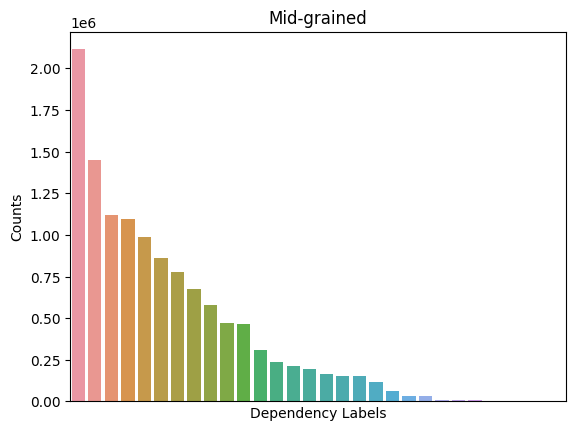

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

words = list(sorted_word_counts.keys())
counts = list(sorted_word_counts.values())

sns.barplot(x=words, y=counts)
plt.title('Mid-grained')
plt.xlabel('Dependency Labels')  # setting x-axis label
plt.ylabel('Counts')
plt.xticks([], [])  # remove x-axis tick labels

plt.savefig("deplabel_freq_mid.pdf", format='pdf')  # Save plot as PDF

plt.show()  # Display the plot


# check negations

In [ ]:
# Function to count negations in a sentence
def count_negations(sentence):
    negation_words = ['not', 'no', 'none', 'neither', 'never', 'nobody']
    words = sentence.lower().split()
    count = sum(1 for word in words if word in negation_words)
    return count

#count downward operators from https://arxiv.org/pdf/1906.06448v2.pdf
def count_downward_monotone_operators(sentence):
    operators = ['every', 'all', 'any', 'few', 'no', 'not', 'never', 'deny', 'prohibit', 'avoid', 'absence of', 'lack of', 'prohibition', 'scarcely', 'hardly', 'rarely', 'seldom', 'without', 'except', 'but', 'if', 'when', 'in case that', 'provided that', 'unless']
    words = sentence#sentence.lower().split()
    count = sum(1 for word in words if word in operators)
    return count


In [ ]:
#SNLI
from zipfile import ZipFile
# specifying the zip file name
file_name = "SNLI_noHOB.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()

file_name = "MNLI_train_noHOB.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()

File Name                                             Modified             Size
SNLI_val.pickle                                2023-02-08 19:39:56      9090645
SNLI_val_hard.pickle                           2023-02-09 14:08:20      2838297
SNLI_train_noHOB.pickle                        2023-04-30 14:24:04    163979239
File Name                                             Modified             Size
MNLI_train_noHOB.pickle                        2023-06-06 11:48:28    190560024


In [ ]:
sick

,gold_label,sentence1,sentence2,text_sentence1,text_sentence2,pos_sentence1,pos_sentence2,heads_sentence1,heads_sentence2,deprel_sentence1,deprel_sentence2,sentence1_parse,sentence2_parse
8,"[0, 0, 1]",A boy is jumping on skateboard in the middle o...,The boy is wearing safety equipment.,"[A, boy, is, jumping, on, skateboard, in, the,...","[The, boy, is, wearing, safety, equipment, .]","[DT, NN, VBZ, VBG, IN, NN, IN, DT, NN, IN, DT,...","[DT, NN, VBZ, VBG, NN, NN, .]","[2, 4, 4, 0, 6, 4, 9, 9, 4, 13, 13, 13, 9, 4]","[2, 4, 4, 0, 6, 4, 4]","[det, nsubj, aux, root, case, obl, case, det, ...","[det, nsubj, aux, root, compound, obj, punct]",(ROOT (S (NP (DT A) (NN boy)) (VP (VBZ is) (VP...,(ROOT (S (NP (DT The) (NN boy)) (VP (VBZ is) (...
11,"[0, 0, 1]",An older man sits with his orange juice at a s...,An elderly man sits in a small shop.,"[An, older, man, sits, with, his, orange, juic...","[An, elderly, man, sits, in, a, small, shop, .]","[DT, JJR, NN, VBZ, IN, PRP$, JJ, NN, IN, DT, J...","[DT, JJ, NN, VBZ, IN, DT, JJ, NN, .]","[3, 3, 4, 0, 8, 8, 8, 4, 12, 12, 12, 4, 16, 16...","[3, 3, 4, 0, 8, 8, 8, 4, 4]","[det, amod, nsubj, root, case, nmod:poss, amod...","[det, amod, nsubj, root, case, det, amod, obl,...",(ROOT (S (NP (DT An) (JJR older) (NN man)) (VP...,(ROOT (S (NP (DT An) (JJ elderly) (NN man)) (V...
15,"[0, 0, 1]","A few people in a restaurant setting, one of t...",The people are eating omelettes.,"[A, few, people, in, a, restaurant, setting, ,...","[The, people, are, eating, omelettes, .]","[DT, JJ, NNS, IN, DT, NN, NN, ,, CD, IN, PRP, ...","[DT, NNS, VBP, VBG, NNS, .]","[3, 3, 13, 7, 7, 7, 3, 13, 13, 11, 9, 13, 0, 1...","[2, 4, 4, 0, 4, 4]","[det, amod, nsubj, case, det, compound, nmod, ...","[det, nsubj, aux, root, obj, punct]",(ROOT (S (NP (NP (DT A) (JJ few) (NNS people))...,(ROOT (S (NP (DT The) (NNS people)) (VP (VBP a...
17,"[0, 1, 0]","A few people in a restaurant setting, one of t...",The diners are at a restaurant.,"[A, few, people, in, a, restaurant, setting, ,...","[The, diners, are, at, a, restaurant, .]","[DT, JJ, NNS, IN, DT, NN, NN, ,, CD, IN, PRP, ...","[DT, NNS, VBP, IN, DT, NN, .]","[3, 3, 13, 7, 7, 7, 3, 13, 13, 11, 9, 13, 0, 1...","[2, 6, 6, 6, 6, 0, 6]","[det, amod, nsubj, case, det, compound, nmod, ...","[det, nsubj, cop, case, det, root, punct]",(ROOT (S (NP (NP (DT A) (JJ few) (NNS people))...,(ROOT (S (NP (DT The) (NNS diners)) (VP (VBP a...
18,"[0, 1, 0]",An older man is drinking orange juice at a res...,A man is drinking juice.,"[An, older, man, is, drinking, orange, juice, ...","[A, man, is, drinking, juice, .]","[DT, JJR, NN, VBZ, VBG, JJ, NN, IN, DT, NN, .]","[DT, NN, VBZ, VBG, NN, .]","[3, 3, 5, 5, 0, 7, 5, 10, 10, 5, 5]","[2, 4, 4, 5, 0, 4]","[det, amod, nsubj, aux, root, amod, obj, case,...","[det, nsubj, aux, compound, root, punct]",(ROOT (S (NP (DT An) (JJR older) (NN man)) (VP...,(ROOT (S (NP (DT A) (NN man)) (VP (VBZ is) (NP...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
550134,"[1, 0, 0]",A group of people in orange life vests are boa...,The life vests are red.,"[A, group, of, people, in, orange, life, vests...","[The, life, vests, are, red, .]","[DT, NN, IN, NNS, IN, JJ, NN, NNS, VBP, VBG, N...","[DT, NN, NNS, VBP, JJ, .]","[2, 10, 4, 2, 8, 7, 8, 4, 10, 0, 10, 14, 14, 1...","[3, 3, 5, 5, 0, 5]","[det, nsubj, case, nmod, case, amod, compound,...","[det, compound, nsubj, cop, root, punct]",(ROOT (S (NP (NP (DT A) (NN group)) (PP (IN of...,(ROOT (S (NP (DT The) (NN life) (NNS vests)) (...
550141,"[1, 0, 0]",a kid doing tricks on a skateboard on a bridge,a kid is inside,"[a, kid, doing, tricks, on, a, skateboard, on,...","[a, kid, is, inside]","[DT, NN, VBG, NNS, IN, DT, NN, IN, DT, NN]","[DT, NN, VBZ, RB]","[2, 0, 2, 3, 7, 7, 3, 10, 10, 3]","[2, 4, 4, 0]","[det, root, acl, obj, case, det, obl, case, de...","[det, nsubj, cop, root]",(ROOT (NP (NP (DT a) (NN kid)) (VP (VBG doing)...,(ROOT (S (NP (DT a) (NN kid)) (VP (VBZ is) (AD...
550147,"[1, 0, 0]",Four dirty and barefoote

In [ ]:
df= pd.read_pickle('MNLI_train_noHOB.pickle')
# c = sick[sick['gold_label']=='neutral']
df['sentence1_downward_operator'] = df['text_sentence1'].apply(count_downward_monotone_operators)
df['sentence2_downward_operator'] = df['text_sentence2'].apply(count_downward_monotone_operators)


s1_neg = df['sentence1_downward_operator'].sum()
s2_neg = df['sentence2_downward_operator'].sum()
print(f"s1_neg: {s1_neg}")
print(f"s2_neg: {s2_neg}")
print(len(df))

s1_neg: 79790
s2_neg: 40637
183029


In [ ]:
len(df)

183632

In [ ]:
sick= pd.read_pickle('sick_train.pickle')
c = sick[sick['gold_label']=='neutral']
c['sentence1_downward_operator'] = c['sentence1'].apply(count_downward_monotone_operators)
c['sentence2_downward_operator'] = c['sentence2'].apply(count_downward_monotone_operators)


s1_neg = c['sentence1_downward_operator'].sum()
s2_neg = c['sentence2_downward_operator'].sum()
print(f"s1_neg: {s1_neg}")
print(f"s2_neg: {s2_neg}")


In [ ]:
snli= pd.read_pickle('SNLI_train.pickle')
c = snli
c['sentence1_downward_operator'] = c['sentence1'].apply(count_downward_monotone_operators)
c['sentence2_downward_operator'] = c['sentence2'].apply(count_downward_monotone_operators)


s1_neg = c['sentence1_downward_operator'].sum()
s2_neg = c['sentence2_downward_operator'].sum()
print(f"s1_neg: {s1_neg}")
print(f"s2_neg: {s2_neg}")


In [ ]:
import pandas as pd
help = pd.read_pickle('HELP_train.pickle')
c = help
c['sentence1_downward_operator'] = c['sentence1'].apply(count_downward_monotone_operators)
c['sentence2_downward_operator'] = c['sentence2'].apply(count_downward_monotone_operators)


s1_neg = c['sentence1_downward_operator'].sum()
s2_neg = c['sentence2_downward_operator'].sum()
print(f"s1_neg: {s1_neg}")
print(f"s2_neg: {s2_neg}")


In [ ]:
sick= pd.read_pickle('sick_train.pickle')
c = sick[sick['gold_label']=='contradiction']
c['sentence1_negations'] = c['sentence1'].apply(count_negations)
c['sentence2_negations'] = c['sentence2'].apply(count_negations)

c = c[(c['sentence1_negations'] != 0) | (c['sentence2_negations'] != 0)]

# s1_neg = c['sentence1_negations'].sum()
# s2_neg = c['sentence2_negations'].sum()
# print(f"s1_neg: {s1_neg}")
# print(f"s2_neg: {s2_neg}")

len(c)


In [ ]:
c[c['sentence1_negations']!=c['sentence2_negations']]['sentence1_negations'].count()

In [ ]:
snli= pd.read_pickle('SNLI_train.pickle')
c = snli[snli['gold_label']=='contradiction']
c['sentence1_negations'] = c['sentence1'].apply(count_negations)
c['sentence2_negations'] = c['sentence2'].apply(count_negations)

s1_neg = c['sentence1_negations'].sum()
s2_neg = c['sentence2_negations'].sum()
print(f"s1_neg: {s1_neg}")
print(f"s2_neg: {s2_neg}")

##analysis of dep label frequency when clustering on HANS

In [ ]:
hans = read_dropna_encode_dataframe('HANS_val.pickle', le, False, is_hans=True, is_mnli=False)
# hans = apply_clustering_dependency_labels(hans, dep_label_mappings, -1)


In [ ]:
from collections import Counter

word_counts = Counter()

# loop through each list of words in the 'words' column
for column in ['deprel_sentence1', 'deprel_sentence2']:
    for word_list in hans[column]:
        word_counts.update(word_list)

sorted_word_counts = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True))
sorted_word_counts

In [ ]:
len(sorted_word_counts)

# !Error analysis

In [ ]:
# load dataset
df= pd.read_pickle('HANS_val.pickle')

#load HANS heuristics/subcases
df['heuristics']=pd.read_pickle('HANS_val_original.pickle')['heuristic']
df['subcase']=pd.read_pickle('HANS_val_original.pickle')['subcase']


df=df[df['gold_label']!='-']
df['true_label']=true_hans

# load model

df['base']=get_pickled_predictions('base_preds_hans.pickle')
df['constGCN']=get_pickled_predictions('constGCN_preds_hans.pickle')
df['depGCN']=get_pickled_predictions('depGCN_preds_hans.pickle')
df['hesyfu']=get_pickled_predictions('cahesyfu_preds_hans.pickle')

df_without_features = df[['sentence1','sentence2', 'heuristics', 'subcase', 'true_label', 'base','constGCN','depGCN','hesyfu']]

In [ ]:
!pip install stanza
import stanza
import graphviz
from IPython.display import SVG
stanza.download('en')
nlp = stanza.Pipeline('en',processors='tokenize,mwt,pos,lemma,depparse')


## visualize dependency trees

In [ ]:
# from IPython.display import display, HTML, SVG
# from graphviz import Digraph

# #create graph in graphviz
# def visualize_dependency_tree(doc):
#     dot = graphviz.Digraph()
#     for sentence in doc.sentences:
#         for word in sentence.words:
#             dot.node(str(word.id), word.text)
#             if word.head > 0:
#                 dot.edge(str(word.head), str(word.id), label=word.deprel)
#     return dot
# def display_svg_side_by_side(svg1, svg2, title1, title2,heuristic,subcase):
#     svg1_data = svg1.data
#     svg2_data = svg2.data
#     table = f"""
#     <table>
#         <tr>
#             <th>Heuristic: {heuristic}, </th>
#             <th>Subcase: {subcase}</th>
#         </tr>
#         <tr>
#             <th>S1: {title1}</th>
#             <th>S2: {title2}</th>
#         </tr>
#         <tr>
#             <td>{svg1_data}</td>
#             <td>{svg2_data}</td>
#         </tr>
#     </table>
#     """
#     display(HTML(table))


# #constituency tree
# def tree_to_svg(tree):
#     def add_subtree(node, dot):
#         node_id = f"{id(node)}"
#         if isinstance(node, str):
#             dot.node(node_id, node)
#         else:
#             label = node.label()
#             dot.node(node_id, label)
#             for child in node:
#                 child_id = add_subtree(child, dot)
#                 dot.edge(node_id, child_id)
#         return node_id

#     dot = Digraph()
#     add_subtree(tree, dot)
#     return SVG(dot.pipe(format='svg'))


## get tree similarity by subcase

In [ ]:
df['subcase'].unique()

In [ ]:
# replace tokens by 'x'
c_dict= {'NP': 0, 'DT': 1, 'NN': 2, 'PP': 3, 'IN': 4, 'S': 5, 'VP': 6, 'VBZ': 7, 'ADJP': 8, 'VBN': 9, 'RP': 10, '.': 11, 'VBG': 12, 'PRP$': 13, ',': 14, 'ADVP': 15, 'RB': 16, 'NNS': 17, 'CC': 18, 'PRP': 19, 'VBP': 20, 'EX': 21, 'JJ': 22, 'JJR': 23, 'SBAR': 24, 'TO': 25, 'VB': 26, 'CD': 27, 'HYPH': 28, 'WHNP': 29, 'WP': 30, 'VBD': 31, 'PRT': 32, 'NML': 33, 'NNP': 34, 'WHADVP': 35, 'WRB': 36, 'WDT': 37, 'POS': 38, 'QP': 39, 'WHADJP': 40, 'MD': 41, '``': 42, 'NNPS': 43, "''": 44, 'PDT': 45, 'RBR': 46, 'JJS': 47, 'UH': 48, 'UCP': 49, 'WHPP': 50, 'AFX': 51, 'SYM': 52, 'SINV': 53, 'X': 54, 'CONJP': 55, 'NFP': 56, 'FRAG': 57, 'WP$': 58, ':': 59, '-LRB-': 60, '-RRB-': 61, 'SBARQ': 62, 'SQ': 63, 'FW': 64, 'PRN': 65, 'INTJ': 66, 'RBS': 67, '$': 68, 'ADD': 69, 'RRC': 70, 'LST': 71, 'LS': 72, 'GW': 73}

df['sentence1_parse_transformed'] = df['sentence1_parse'].str.replace('(', '', regex=False)
df['sentence1_parse_transformed'] = df['sentence1_parse_transformed'].str.replace('ROOT', '', regex=False)
df['sentence1_parse_transformed'] = df['sentence1_parse_transformed'].apply(lambda x: ' '.join(['x' if word not in c_dict else word for word in x.split()]))

df['sentence2_parse_transformed'] = df['sentence2_parse'].str.replace('(', '', regex=False)
df['sentence2_parse_transformed'] = df['sentence2_parse_transformed'].str.replace('ROOT', '', regex=False)
df['sentence2_parse_transformed'] = df['sentence2_parse_transformed'].apply(lambda x: ' '.join(['x' if word not in c_dict else word for word in x.split()]))

In [ ]:
subcase_df=df[df['subcase']=='cn_disjunction']
# incorrect_df

In [ ]:
model='depGCN'

subcases = df['subcase'].unique()

for subcase in subcases:
    print(subcase)
    subcase_df=df[df['subcase']==subcase]
    accuracy = get_accuracy(subcase_df['true_label'], subcase_df[model])
    incorrect=subcase_df[subcase_df['true_label']!=subcase_df[model]]
    correct=subcase_df[subcase_df['true_label']==subcase_df[model]]

    if len(correct)>0:
        correct_copy = correct.copy()
        correct_similarity = correct_copy.apply(calculate_dep_tree_similarity, axis=1).mean()
    else:
        correct_similarity=0
    if len(incorrect)>0:
        incorrect_copy = incorrect.copy()
        incorrect_similarity = incorrect_copy.apply(calculate_dep_tree_similarity, axis=1).mean()
    else:
        incorrect_similarity=0


    # correct_mean_tree_distance = correct_copy['dep_similarity']
    # incorrect_mean_tree_distance = incorrect_copy['dep_similarity']
    print("Correct Mean Tree Similarity: %.2f, Incorrect Mean Tree Similarity: %.2f, Accuracy: %.2f" % (correct_similarity, incorrect_similarity, accuracy))


In [ ]:
#check by subcase
subcases = df['subcase'].unique()

for subcase in subcases:
    subcase_df=df[df['subcase']==subcase]

    subcase_df = subcase_df.copy()
    correct_similarity = round(subcase_df.apply(calculate_dep_tree_similarity, axis=1).mean(), 2)
    print(f"{subcase}, Correct Similarity: {correct_similarity}")


In [ ]:
#constituency tree similarity by subcase
import statistics
#check by subcase
subcases = df['subcase'].unique()

for subcase in subcases:
    subcase_df=df[df['subcase']==subcase]

    subcase_df = subcase_df.copy()
    correct_similarity = round(statistics.mean(calculate_const_tree_similarity(subcase_df)),2)
    print(f"{subcase}, Correct Similarity: {correct_similarity}")


In [ ]:
df_filtered = correct[correct['deprel_sentence2'].apply(lambda x: 'xcomp' in x)]
df_filtered

In [ ]:
parse = 'S NP DT x NNS x VP VBD x S NP DT x NNS x . x'

df_filtered = incorrect[incorrect['sentence1_parse_transformed'].apply(lambda x: parse in x)]
df_filtered

In [ ]:
#checking unique dependency parses
unique_values1 = set(incorrect['deprel_sentence1'].apply(' '.join))
unique_values2 = set(incorrect['deprel_sentence2'].apply(' '.join))
print('incorrect')
print('sentence1')
for item in unique_values1:
    print(item)
print('sentence2')
for item in unique_values2:
    print(item)


unique_values1 = set(correct['deprel_sentence1'].apply(' '.join))
unique_values2 = set(correct['deprel_sentence2'].apply(' '.join))
print('correct')
print('sentence1')
for item in unique_values1:
    print(item)
print('sentence2')
for item in unique_values2:
    print(item)

In [ ]:
#checking unique constituency parses
#checking unique dependency parses
unique_values1 = incorrect['sentence1_parse_transformed'].unique()
unique_values2 = incorrect['sentence2_parse_transformed'].unique()
print('incorrect')
print('sentence1\n', unique_values1)
print('sentence2\n',unique_values2)

unique_values1 = correct['sentence1_parse_transformed'].unique()
unique_values2 = correct['sentence1_parse_transformed'].unique()
print('correct')
print('sentence1\n', unique_values1)
print('sentence2\n',unique_values2)

In [ ]:
subcase_df

In [ ]:

df_without_features.loc[row]

In [ ]:
row = 23001

#sentence1
sentence1 = df['sentence1'][row]
doc1 = nlp(sentence1)
dep_heads = df['heads_sentence1'][row]
deprels = df['deprel_sentence1'][row]
# Update the dependency information in the Doc object
for i, token in enumerate(doc1.sentences[0].tokens):
    token.words[0].head = dep_heads[i]
    token.words[0].deprel = deprels[i]


#sentence2
sentence2 = df['sentence2'][row]
doc2 = nlp(sentence2)
dep_heads = df['heads_sentence2'][row]
deprels = df['deprel_sentence2'][row]
# Update the dependency information in the Doc object
for i, token in enumerate(doc2.sentences[0].tokens):
    token.words[0].head = dep_heads[i]
    token.words[0].deprel = deprels[i]

heuristic = df['heuristics'][row]
subcase = df['subcase'][row]
# Visualize the dependency tree in the Colab cell
tree1 = dependency_tree_to_graphviz(doc1)
svg1=SVG(tree1.pipe(format='svg'))
# Visualize the dependency tree in the Colab cell
tree2 = dependency_tree_to_graphviz(doc2)
svg2=SVG(tree2.pipe(format='svg'))
display_svg_side_by_side(svg1, svg2, sentence1, sentence2,heuristic,subcase)

## visualize constituency trees

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
df = pd.read_pickle('SNLI_train.pickle')
df

In [ ]:
snli_train = pd.read_pickle('SNLI_train.pickle')
snli_train['distances'] = calculate_const_tree_similarity(snli_train)
avg_distance = snli_train['distances'].mean()

#entailment label
e = snli_train[snli_train['gold_label']=='entailment']['distances']
#neutral label
n = snli_train[snli_train['gold_label']=='neutral']['distances']
#contradiction label
c = snli_train[snli_train['gold_label']=='contradiction']['distances']

e

In [ ]:
# top_50_rows = snli_train.nlargest(50, 'distances')
# top_50_rows

filtered_df = snli_train[snli_train['distances'] <= 0.8]
top_10_rows = filtered_df.nlargest(10, 'distances')
top_10_rows

In [ ]:
row= 40283
tree1 = df['sentence1_parse'][row]
tree2 = df['sentence2_parse'][row]

sentence1=df['sentence1'][row]
sentence2=df['sentence2'][row]

parsed_tree1 = nltk.Tree.fromstring(tree1)
parsed_tree2 = nltk.Tree.fromstring(tree2)

svg1 = tree_to_svg(parsed_tree1)
svg2 = tree_to_svg(parsed_tree2)
display_svg_side_by_side(svg1, svg2, sentence1, sentence2 ,"","")


## hans

In [ ]:
hans = pd.read_pickle('HANS_val.pickle')
hans['subcase']=pd.read_pickle('HANS_val_original.pickle')['subcase']
# hans = pd.read_pickle('HANS_val_original.pickle')
# hans['sentence1_parse'] = hans['sentence1_parse'].apply(lambda x: replace_words_not_in_dict(x, c_dict,pos_dict))
# hans['sentence2_parse'] = hans['sentence2_parse'].apply(lambda x: replace_words_not_in_dict(x, c_dict,pos_dict))
hans

,gold_label,sentence1,sentence2,text_sentence1,text_sentence2,pos_sentence1,pos_sentence2,heads_sentence1,heads_sentence2,deprel_sentence1,deprel_sentence2,sentence1_parse,sentence2_parse,subcase
0,1,The president advised the doctor .,The doctor advised the president .,"[The, president, advised, the, doctor, .]","[The, doctor, advised, the, president, .]","[DT, NN, VBD, DT, NN, .]","[DT, NN, VBD, DT, NN, .]","[2, 3, 0, 5, 3, 3]","[2, 3, 0, 5, 3, 3]","[det, nsubj, root, det, obj, punct]","[det, nsubj, root, det, obj, punct]",(ROOT (S (NP (DT The) (NN president)) (VP (VBD...,(ROOT (S (NP (DT The) (NN doctor)) (VP (VBD ad...,ln_subject/object_swap
1,1,The student saw the managers .,The managers saw the student .,"[The, student, saw, the, managers, .]","[The, managers, saw, the, student, .]","[DT, NN, VBD, DT, NNS, .]","[DT, NNS, VBD, DT, NN, .]","[2, 3, 0, 5, 3, 3]","[2, 3, 0, 5, 3, 3]","[det, nsubj, root, det, obj, punct]","[det, nsubj, root, det, obj, punct]",(ROOT (S (NP (DT The) (NN student)) (VP (VBD s...,(ROOT (S (NP (DT The) (NNS managers)) (VP (VBD...,ln_subject/object_swap
2,1,The presidents encouraged the banker .,The banker encouraged the presidents .,"[The, presidents, encouraged, the, banker, .]","[The, banker, encouraged, the, presidents, .]","[DT, NNS, VBD, DT, NN, .]","[DT, NN, VBD, DT, NNS, .]","[2, 3, 0, 5, 3, 3]","[2, 3, 0, 5, 3, 3]","[det, nsubj, root, det, obj, punct]","[det, nsubj, root, det, obj, punct]",(ROOT (S (NP (DT The) (NNS presidents)) (VP (V...,(ROOT (S (NP (DT The) (NN banker)) (VP (VBD en...,ln_subject/object_swap
3,1,The senators supported the actor .,The actor supported the senators .,"[The, senators, supported, the, actor, .]","[The, actor, supported, the, senators, .]","[DT, NNS, VBD, DT, NN, .]","[DT, NN, VBD, DT, NNS, .]","[2, 3, 0, 5, 3, 3]","[2, 3, 0, 5, 3, 3]","[det, nsubj, root, det, obj, punct]","[det, nsubj, root, det, obj, punct]",(ROOT (S (NP (DT The) (NNS senators)) (VP (VBD...,(ROOT (S (NP (DT The) (NN actor)) (VP (VBD sup...,ln_subject/object_swap
4,1,The actors avoided the bankers .,The bankers avoided the actors .,"[The, actors, avoided, the, bankers, .]","[The, bankers, avoided, the, actors, .]","[DT, NNS, VBD, DT, NNS, .]","[DT, NNS, VBD, DT, NNS, .]","[2, 3, 0, 5, 3, 3]","[2, 3, 0, 5, 3, 3]","[det, nsubj, root, det, obj, punct]","[det, nsubj, root, det, obj, punct]",(ROOT (S (NP (DT The) (NNS actors)) (VP (VBD a...,(ROOT (S (NP (DT The) (NNS bankers)) (VP (VBD ...,ln_subject/object_swap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,Obviously the senator avoided the professor .,The senator avoided the professor .,"[Obviously, the, senator, avoided, the, profes...","[The, senator, avoided, the, professor, .]","[RB, DT, NN, VBD, DT, NN, .]","[DT, NN, VBD, DT, NN, .]","[4, 3, 4, 0, 6, 4, 4]","[2, 3, 0, 5, 3, 3]","[advmod, det, nsubj, root, det, obj, punct]","[det, nsubj, root, det, obj, punct]",(ROOT (S (ADVP (RB Obviously)) (NP (DT the) (N...,(ROOT (S (NP (DT The) (NN senator)) (VP (VBD a...,ce_adverb
29996,0,Certainly the senators recognized the actor .,The senators recognized the actor .,"[Certainly, the, senators, recognized, the, ac...","[The, senators, recognized, the, actor, .]","[RB, DT, NNS, VBD, DT, NN, .]","[DT, NNS, VBD, DT, NN, .]","[4, 3, 4, 0, 6, 4, 4]","[2, 3, 0, 5, 3, 3]","[advmod, det, nsubj, root, det, obj, punct]","[det, nsubj, root, det, obj, punct]",(ROOT (S (ADVP (RB Certainly)) (NP (DT the) (N...,(ROOT (S (NP (DT The) (NNS senators)) (VP (VBD...,ce_adverb
29997,0,Obviously the artists ran .,The artists ran .,"[Obviously, the, artists, ran, .]","[The, artists, ran, .]","[RB, DT, NNS, VBD, .]","[DT, NNS, VBD, .]","[4, 3, 4, 0, 4]","[2, 3, 0, 3]","[advmod, det, nsubj, root, punct]","[det, nsubj, root, punct]",(ROOT (S (ADVP (RB Obviously)) (NP (DT the) (N...,(ROOT (S (NP (DT The) (NNS artists)) (VP (VBD ...,ce_adverb
29998,0,Suddenly the tourists supported the judges .,The tourists supported the judges .,"[Suddenly, the, tourists, suppo

In [ ]:
hans['subcase'].unique()

array(['ln_subject/object_swap', 'ln_preposition', 'ln_relative_clause',
       'ln_passive', 'ln_conjunction', 'le_relative_clause',
       'le_around_prepositional_phrase', 'le_around_relative_clause',
       'le_conjunction', 'le_passive', 'sn_NP/S', 'sn_PP_on_subject',
       'sn_relative_clause_on_subject', 'sn_past_participle', 'sn_NP/Z',
       'se_conjunction', 'se_adjective', 'se_understood_object',
       'se_relative_clause_on_obj', 'se_PP_on_obj',
       'cn_embedded_under_if', 'cn_after_if_clause',
       'cn_embedded_under_verb', 'cn_disjunction', 'cn_adverb',
       'ce_embedded_under_since', 'ce_after_since_clause',
       'ce_embedded_under_verb', 'ce_conjunction', 'ce_adverb'],
      dtype=object)

In [ ]:
# Set the display.max_colwidth option to None
pd.set_option('display.max_colwidth', None)
subcase = hans[hans['subcase']=='ln_passive']
subcase

,gold_label,sentence1,sentence2,text_sentence1,text_sentence2,pos_sentence1,pos_sentence2,heads_sentence1,heads_sentence2,deprel_sentence1,deprel_sentence2,sentence1_parse,sentence2_parse,subcase
3000,1,The managers were advised by the athlete .,The managers advised the athlete .,"[The, managers, were, advised, by, the, athlete, .]","[The, managers, advised, the, athlete, .]","[DT, NNS, VBD, VBN, IN, DT, NN, .]","[DT, NNS, VBD, DT, NN, .]","[2, 4, 4, 0, 7, 7, 4, 4]","[2, 3, 0, 5, 3, 3]","[det, nsubj:pass, aux:pass, root, case, det, obl:agent, punct]","[det, nsubj, root, det, obj, punct]",(ROOT (S (NP (DT The) (NNS managers)) (VP (VBD were) (VP (VBN advised) (PP (IN by) (NP (DT the) (NN athlete))))) (. .))),(ROOT (S (NP (DT The) (NNS managers)) (VP (VBD advised) (NP (DT the) (NN athlete))) (. .))),ln_passive
3001,1,The lawyers were recommended by the doctor .,The lawyers recommended the doctor .,"[The, lawyers, were, recommended, by, the, doctor, .]","[The, lawyers, recommended, the, doctor, .]","[DT, NNS, VBD, VBN, IN, DT, NN, .]","[DT, NNS, VBD, DT, NN, .]","[2, 4, 4, 0, 7, 7, 4, 4]","[2, 3, 0, 5, 3, 3]","[det, nsubj:pass, aux:pass, root, case, det, obl:agent, punct]","[det, nsubj, root, det, obj, punct]",(ROOT (S (NP (DT The) (NNS lawyers)) (VP (VBD were) (VP (VBN recommended) (PP (IN by) (NP (DT the) (NN doctor))))) (. .))),(ROOT (S (NP (DT The) (NNS lawyers)) (VP (VBD recommended) (NP (DT the) (NN doctor))) (. .))),ln_passive
3002,1,The presidents were stopped by the artist .,The presidents stopped the artist .,"[The, presidents, were, stopped, by, the, artist, .]","[The, presidents, stopped, the, artist, .]","[DT, NNS, VBD, VBN, IN, DT, NN, .]","[DT, NNS, VBD, DT, NN, .]","[2, 4, 4, 0, 7, 7, 4, 4]","[2, 3, 0, 5, 3, 3]","[det, nsubj:pass, aux:pass, root, case, det, obl:agent, punct]","[det, nsubj, root, det, obj, punct]",(ROOT (S (NP (DT The) (NNS presidents)) (VP (VBD were) (VP (VBN stopped) (PP (IN by) (NP (DT the) (NN artist))))) (. .))),(ROOT (S (NP (DT The) (NNS presidents)) (VP (VBD stopped) (NP (DT the) (NN artist))) (. .))),ln_passive
3003,1,The managers were introduced by the scientists .,The managers introduced the scientists .,"[The, managers, were, introduced, by, the, scientists, .]","[The, managers, introduced, the, scientists, .]","[DT, NNS, VBD, VBN, IN, DT, NNS, .]","[DT, NNS, VBD, DT, NNS, .]","[2, 4, 4, 0, 7, 7, 4, 4]","[2, 3, 0, 5, 3, 3]","[det, nsubj:pass, aux:pass, root, case, det, obl:agent, punct]","[det, nsubj, root, det, obj, punct]",(ROOT (S (NP (DT The) (NNS managers)) (VP (VBD were) (VP (VBN introduced) (PP (IN by) (NP (DT the) (NNS scientists))))) (. .))),(ROOT (S (NP (DT The) (NNS managers)) (VP (VBD introduced) (NP (DT the) (NNS scientists))) (. .))),ln_passive
3004,1,The students were recognized by the president .,The students recognized the president .,"[The, students, were, recognized, by, the, president, .]","[The, students, recognized, the, president, .]","[DT, NNS, VBD, VBN, IN, DT, NN, .]","[DT, NNS, VBD, DT, NN, .]","[2, 4, 4, 0, 7, 7, 4, 4]","[2, 3, 0, 5, 3, 3]","[det, nsubj:pass, aux:pass, root, case, det, obl:agent, punct]","[det, nsubj, root, det, obj, punct]",(ROOT (S (NP (DT The) (NNS students)) (VP (VBD were) (VP (VBN recognized) (PP (IN by) (NP (DT the) (NN president))))) (. .))),(ROOT (S (NP (DT The) (NNS students)) (VP (VBD recognized) (NP (DT the) (NN president))) (. .))),ln_passive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,The actors were mentioned by the judges .,The actors mentioned the judges .,"[The, actors, were, mentioned, by, the, judges, .]","[The, actors, mentioned, the, judges, .]","[DT, NNS, VBD, VBN, IN, DT, NNS, .]","[DT, NNS, VBD, DT, NNS, .]","[2, 4, 4, 0, 7, 7, 4, 4]","[2, 3, 0, 5, 3, 3]","[det, nsubj:pass, aux:pass, root, case, det, obl:agent, punct]","[det, nsubj, root, det, obj, punct]",(ROOT (S (NP (DT The) (NNS actors)) (VP (VBD were) (VP (VBN mentioned) (PP (IN by) (NP (DT the) (NNS judges))))) (. .))),(ROOT (S (NP (DT The) (

In [ ]:
!pip install stanza
import stanza
import graphviz
from IPython.display import SVG
stanza.download('en')
nlp = stanza.Pipeline('en',processors='tokenize,mwt,pos,lemma,depparse')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.5/802.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.6/356.6 kB 27.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351311 sha256=a66a8c30444d7a1fb17d868d2835691758ba74dcf4061ef37ee64586ed4f2092
  Stored in directory: /root/.cache/pip/wheels/ea/0b/64/114bc939d0083621aa41521e21be246c888260b8aa21e6c1ad
Successfully built emoji


INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!


In [ ]:
row = hans.loc[hans['sentence1'].str.contains('The tourist believed the students.')]

row

,gold_label,sentence1,sentence2,text_sentence1,text_sentence2,pos_sentence1,pos_sentence2,heads_sentence1,heads_sentence2,deprel_sentence1,deprel_sentence2,sentence1_parse,sentence2_parse,subcase
23,1,The tourist believed the students .,The students believed the tourist .,"[The, tourist, believed, the, students, .]","[The, students, believed, the, tourist, .]","[DT, NN, VBD, DT, NNS, .]","[DT, NNS, VBD, DT, NN, .]","[2, 3, 0, 5, 3, 3]","[2, 3, 0, 5, 3, 3]","[det, nsubj, root, det, obj, punct]","[det, nsubj, root, det, obj, punct]",(ROOT (S (NP (DT The) (NN tourist)) (VP (VBD b...,(ROOT (S (NP (DT The) (NNS students)) (VP (VBD...,ln_subject/object_swap
10092,1,The tourist believed the students helped the m...,The tourist believed the students .,"[The, tourist, believed, the, students, helped...","[The, tourist, believed, the, students, .]","[DT, NN, VBD, DT, NNS, VBD, DT, NN, .]","[DT, NN, VBD, DT, NNS, .]","[2, 3, 0, 5, 6, 3, 8, 6, 3]","[2, 3, 0, 5, 3, 3]","[det, nsubj, root, det, nsubj, ccomp, det, obj...","[det, nsubj, root, det, obj, punct]",(ROOT (S (NP (DT The) (NN tourist)) (VP (VBD b...,(ROOT (S (NP (DT The) (NN tourist)) (VP (VBD b...,sn_NP/S
19571,0,The tourist believed the students in front of ...,The tourist believed the students .,"[The, tourist, believed, the, students, in, fr...","[The, tourist, believed, the, students, .]","[DT, NN, VBD, DT, NNS, IN, NN, IN, DT, NN, .]","[DT, NN, VBD, DT, NNS, .]","[2, 3, 0, 5, 3, 7, 5, 10, 10, 7, 3]","[2, 3, 0, 5, 3, 3]","[det, nsubj, root, det, obj, case, nmod, case,...","[det, nsubj, root, det, obj, punct]",(ROOT (S (NP (DT The) (NN tourist)) (VP (VBD b...,(ROOT (S (NP (DT The) (NN tourist)) (VP (VBD b...,se_PP_on_obj


In [ ]:
row= 23
tree1 = hans['sentence1_parse'][row]
tree2 = hans['sentence2_parse'][row]

sentence1=hans['sentence1'][row]
sentence2=hans['sentence2'][row]

parsed_tree1 = nltk.Tree.fromstring(tree1)
parsed_tree2 = nltk.Tree.fromstring(tree2)

svg1 = tree_to_svg(parsed_tree1)
svg2 = tree_to_svg(parsed_tree2)
display_svg_side_by_side(svg1, svg2, sentence1, sentence2 ,"","")

"Heuristic: ,",Subcase:
S1: The tourist believed the students .,S2: The students believed the tourist .


In [ ]:
row = 3999
df=hans

#sentence1
sentence1 = df['sentence1'][row]
doc1 = nlp(sentence1)
dep_heads = df['heads_sentence1'][row]
deprels = df['deprel_sentence1'][row]
# Update the dependency information in the Doc object
for i, token in enumerate(doc1.sentences[0].tokens):
    token.words[0].head = dep_heads[i]
    token.words[0].deprel = deprels[i]


#sentence2
sentence2 = df['sentence2'][row]
doc2 = nlp(sentence2)
dep_heads = df['heads_sentence2'][row]
deprels = df['deprel_sentence2'][row]
# Update the dependency information in the Doc object
for i, token in enumerate(doc2.sentences[0].tokens):
    token.words[0].head = dep_heads[i]
    token.words[0].deprel = deprels[i]


subcase = df['subcase'][row]
# Visualize the dependency tree in the Colab cell
tree1 = dependency_tree_to_graphviz(doc1)
svg1=SVG(tree1.pipe(format='svg'))
# Visualize the dependency tree in the Colab cell
tree2 = dependency_tree_to_graphviz(doc2)
svg2=SVG(tree2.pipe(format='svg'))
display_svg_side_by_side(svg1, svg2, sentence1, sentence2,'',subcase)

# check spelling errors

In [ ]:
!pip install pyspellchecker


In [ ]:
from zipfile import ZipFile

file_name = "SNLI_2validations.zip"

with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()


In [ ]:
dataset=pd.read_pickle('HANS_val.pickle')
dataset

In [ ]:
dataset=pd.read_pickle('sick_train.pickle')

from spellchecker import SpellChecker
import string
def count_spelling_errors(df, col1, col2):
    spell = SpellChecker()
    total_errors = 0
    indices=[]
    misspelled = []

    for index, row in df.iterrows():
        for col in [col1, col2]:
            words = row[col].split()
            words = [word.strip(string.punctuation) for word in words]  # Remove punctuation from each word
            words = [elem for elem in words if elem]
            misspelled_words = spell.unknown(words)

            total_errors += len(misspelled_words)
        if misspelled_words:
            indices.append(index)
            misspelled.append(misspelled_words)
    return total_errors,indices,misspelled

# Example usage
data = dataset[['sentence1','sentence2']]

df = pd.DataFrame(data)
num_errors,indices, misspelled= count_spelling_errors(df, 'sentence1', 'sentence2')
print(f"Total spelling errors: {num_errors}")



In [ ]:

selected_rows = dataset.loc[indices]
selected_rows['misspelled'] = misspelled

selected_rows.drop(columns=['text_sentence1', 'text_sentence2', 'pos_sentence1', 'pos_sentence2'], inplace=True)
selected_rows

In [ ]:
row = 132
df=dataset
#sentence1
sentence1 = df['sentence1'][row]
doc1 = nlp(sentence1)
dep_heads = df['heads_sentence1'][row]
deprels = df['deprel_sentence1'][row]
# Update the dependency information in the Doc object
for i, token in enumerate(doc1.sentences[0].tokens):
    token.words[0].head = dep_heads[i]
    token.words[0].deprel = deprels[i]


#sentence2
sentence2 = df['sentence2'][row]
doc2 = nlp(sentence2)
dep_heads = df['heads_sentence2'][row]
deprels = df['deprel_sentence2'][row]
# Update the dependency information in the Doc object
for i, token in enumerate(doc2.sentences[0].tokens):
    token.words[0].head = dep_heads[i]
    token.words[0].deprel = deprels[i]

heuristic = ""#df['heuristics'][row]
subcase = ""#df['subcase'][row]
# Visualize the dependency tree in the Colab cell
tree1 = visualize_dependency_tree(doc1)
svg1=SVG(tree1.pipe(format='svg'))
# Visualize the dependency tree in the Colab cell
tree2 = visualize_dependency_tree(doc2)
svg2=SVG(tree2.pipe(format='svg'))
display_svg_side_by_side(svg1, svg2, sentence1, sentence2,heuristic,subcase)

# check HELP dataset

In [ ]:
# df=pd.read_pickle('HELP_train.pickle')
df[df['monotonicity']=='conjunction']

In [ ]:
df[(df['monotonicity'] == 'disjunction') & (df['new_sentence'].str.contains('and'))].gold_label.value_counts()


In [ ]:
df[(df['monotonicity'] == 'disjunction') & (df['ori_sentence'].str.contains('and'))].gold_label.value_counts()


# check mnli


In [ ]:
from zipfile import ZipFile
file_name = "MNLI_train.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()

In [ ]:
import pandas as pd

mnli=pd.read_pickle('MNLI_train.pickle')
mnli

In [ ]:

max_length1 = mnli['text_sentence1'].apply(len)
max_length2 = mnli['text_sentence2'].apply(len)

print("Max length:", (max_length1+max_length2).max())


In [ ]:
max_length > 100

In [ ]:
mnli.loc[max_length>100]

In [ ]:
# !pip install datasets
from datasets import load_dataset
mnli = load_dataset("multi_nli")

df_train=pd.DataFrame(mnli['train'])

In [ ]:
df_train.loc[max_length>100]

In [ ]:
i=145695
" ".join(mnli.loc[i]['text_sentence1'])

In [ ]:
%cd ..

In [ ]:

from zipfile import ZipFile
file_name = "MNLI_train_part2.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()

In [ ]:
df=pd.read_pickle('MNLI_train_part2.pickle')
df.loc[i]

In [ ]:
df.loc[i]['sentence1']

# Agreement rates on MED


*   calculate agreement rates on MED dataset for base model and syntax models trained on SNLI
*   calculate agreement rates on MED dataset for base model and syntax models trained on SNLI+HELP

Q: do they have similar predictions on MED



In [ ]:
base = np.array(get_pickled_predictions('base_preds_wanli.pickle'))

other = np.array(get_pickled_predictions('constGCN_preds_wanli.pickle'))

round((base==other).mean()*100,2)

88.14

In [ ]:
len(base)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Compute the confusion matrix
cm = confusion_matrix(base, other, normalize='true')

# Use Seaborn to visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.ylabel('BERT')
plt.xlabel('Other')
plt.show()

# McNemar

In [ ]:
from zipfile import ZipFile
file_name = "HANS_MED_original.zip"
with ZipFile(file_name, 'r') as zipfile:
    zipfile.printdir()
    zipfile.extractall()

File Name                                             Modified             Size
MED_ver_1.tsv                                  2022-03-17 09:16:02       786647
HANS_val_original.pickle                       2023-01-25 17:22:30     21176662


In [ ]:
# condition by subcase
med = pd.read_csv('MED_ver_1.tsv', sep='\t', on_bad_lines='skip')
indices = med['genre'].str.contains('conj')
indices.sum()

281

In [ ]:
# condition by subcase
hans = pd.read_pickle('HANS_val_original.pickle')
indices = hans['subcase'].str.contains('le_passive')
indices.sum()

In [ ]:
base = np.array(get_pickled_predictions('constGCN_preds_hans.pickle'))#[indices]
other = np.array(get_pickled_predictions('constGCN_preds_hans.pickle'))#[indices]
pred1= base
pred2=other
y_true=np.array(true_hans)#[indices]

import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# Assuming y_true is your ground truth, and pred1 and pred2 are your predictions
table = np.zeros((2, 2))
table[0, 0] = np.sum((pred1 == y_true) & (pred2 == y_true))
table[0, 1] = np.sum((pred1 == y_true) & (pred2 != y_true))
table[1, 0] = np.sum((pred1 != y_true) & (pred2 == y_true))
table[1, 1] = np.sum((pred1 != y_true) & (pred2 != y_true))

result = mcnemar(table, exact=True)

print(f'statistic={result.statistic}, p-value={result.pvalue}')
print(f'statistic={result.statistic}, p-value={round(result.pvalue, 4)}')


statistic=0.0, p-value=1.0
statistic=0.0, p-value=1.0


In [ ]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# Assuming you have N observations for each model
N = len(base)  # replace with your actual number of observations

count = np.array([0.9430 * N, 0.9298 * N])  # number of successes for each model
nobs = np.array([N, N])  # number of observations for each model

# Perform the test
stat, pval = proportions_ztest(count, nobs)

print(f'Z-statistic: {stat:.2f}')
print(f'p-value: {pval:.4f}')
print(pval)


# analyze mnli mistakes

In [ ]:
!pip install datasets
from datasets import load_dataset
mnli = load_dataset("multi_nli")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.7 MB/s eta 0:00:00


Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Dataset multi_nli downloaded and prepared to /root/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

m = pd.DataFrame(mnli['validation_matched'])
mm = pd.DataFrame(mnli['validation_mismatched'])

In [ ]:
genres = mm['genre']
genres

0          letters
1         verbatim
2         verbatim
3          letters
4       facetoface
           ...    
9827    facetoface
9828      verbatim
9829    nineeleven
9830    facetoface
9831      verbatim
Name: genre, Length: 9832, dtype: object

In [ ]:
#in mnli 1=neutral 0=ent 2=contr
#convert to 0=contr, 1=ent, 2=neutr
mapping_dict= {0:1, 1:2, 2:0}
labels = mm['label'].map(mapping_dict)
labels

0       0
1       0
2       1
3       0
4       1
       ..
9827    0
9828    0
9829    0
9830    2
9831    1
Name: label, Length: 9832, dtype: int64

In [ ]:
genres.unique()

array(['letters', 'verbatim', 'facetoface', 'oup', 'nineeleven'],
      dtype=object)

In [ ]:
sentence1=mm['premise']
sentence2=mm['hypothesis']

In [ ]:

preds = np.array(get_pickled_predictions('cahesyfu_preds_mnli_mm.pickle'))

import pandas as pd
from sklearn.metrics import accuracy_score
# Assuming preds, labels, and genres are your numpy arrays
df = pd.DataFrame({
    'sentence1': sentence1,
    'sentence2': sentence2,
    'preds': preds,
    'labels': labels,
    'genres': genres,
})

# Now you can proceed with the groupby operation:
accuracy_by_genre = df.groupby('genres').apply(lambda x: accuracy_score(x['labels'], x['preds'])).round(2)
print(accuracy_by_genre)



genres
facetoface    0.75
letters       0.77
nineeleven    0.76
oup           0.76
verbatim      0.73
dtype: float64


In [ ]:
df

In [ ]:
# Assuming 'sentences' is the column containing the sentences
df['sentence_length'] = df['sentence2'].apply(lambda x: len(x.split()))

# Now group by genre and calculate average sentence length for each group
average_length_by_genre = df.groupby('genres')['sentence_length'].mean().round(2)

print(average_length_by_genre)


In [ ]:
mnli=pd.DataFrame(mnli['train'])
mnli['genre'].unique()

In [ ]:
# agreement rates
base = np.array(get_pickled_predictions('base_preds_mnli_mm.pickle'))

other = np.array(get_pickled_predictions('depGCN_preds_mnli_mm.pickle'))

(base==other).mean()*100

# analyze constituency parsing trees in HANS

In [ ]:
import math
import nltk
def replace_words_not_in_dict(tree_str, c_dict, pos_dict):
    words_to_replace = re.findall(r"[\w']+|\(|\)", tree_str)
    # replace each word with 'x' if it is not in both dictionaries
    for word in words_to_replace :
        if word in pos_dict or word not in c_dict:
            tree_str = tree_str.replace(word, 'x', 1)
    return tree_str

pos_dict = {
    "CC": "Coordinating conjunction",
    "CD": "Cardinal number",
    "EX": "Existential there",
    "FW": "Foreign word",
    "IN": "Preposition or subordinating conjunction",
    "JJR": "Adjective, comparative",
    "JJS": "Adjective, superlative",
    "JJ": "Adjective",
    "LS": "List item marker",
    "MD": "Modal",
    "NNS": "Noun, plural",
    "NNP": "Proper noun, singular",
    "NNPS": "Proper noun, plural",
    "NN": "Noun, singular or mass",
    "PDT": "Predeterminer",
    "DT": "Determiner",
    "POS": "Possessive ending",
    "PRP$": "Possessive pronoun",
    "PRP": "Personal pronoun",
    "RBR": "Adverb, comparative",
    "RBS": "Adverb, superlative",
    "RP": "Particle",
    "SYM": "Symbol",
    "TO": "to",
    "UH": "Interjection",
    "VBD": "Verb, past tense",
    "VBG": "Verb, gerund or present participle",
    "VBN": "Verb, past participle",
    "VBP": "Verb, non-3rd person singular present",
    "VBZ": "Verb, 3rd person singular present",
    "VB": "Verb, base form",
    "WDT": "Wh-determiner",
    "WP$": "Possessive wh-pronoun",
    "WRB": "Wh-adverb",
    "RB": "Adverb",
    "WP": "Wh-pronoun",
}


c_dict= {'(':0, ')':0, 'ROOT':0,'NP': 0, 'DT': 1, 'NN': 2, 'PP': 3, 'IN': 4, 'S': 5, 'VP': 6, 'VBZ': 7, 'ADJP': 8, 'VBN': 9, 'RP': 10, '.': 11, 'VBG': 12, 'PRP$': 13, ',': 14, 'ADVP': 15, 'RB': 16, 'NNS': 17, 'CC': 18, 'PRP': 19, 'VBP': 20, 'EX': 21, 'JJ': 22, 'JJR': 23, 'SBAR': 24, 'TO': 25, 'VB': 26, 'CD': 27, 'HYPH': 28, 'WHNP': 29, 'WP': 30, 'VBD': 31, 'PRT': 32, 'NML': 33, 'NNP': 34, 'WHADVP': 35, 'WRB': 36, 'WDT': 37, 'POS': 38, 'QP': 39, 'WHADJP': 40, 'MD': 41, '``': 42, 'NNPS': 43, "''": 44, 'PDT': 45, 'RBR': 46, 'JJS': 47, 'UH': 48, 'UCP': 49, 'WHPP': 50, 'AFX': 51, 'SYM': 52, 'SINV': 53, 'X': 54, 'CONJP': 55, 'NFP': 56, 'FRAG': 57, 'WP$': 58, ':': 59, '-LRB-': 60, '-RRB-': 61, 'SBARQ': 62, 'SQ': 63, 'FW': 64, 'PRN': 65, 'INTJ': 66, 'RBS': 67, '$': 68, 'ADD': 69, 'RRC': 70, 'LST': 71, 'LS': 72, 'GW': 73}


def tree_kernel_from_NLTK_string(tree1, tree2):
    """
    Compute the similarity between two constituency trees using the subtree kernel.

    The subtree kernel is a similarity measure that counts the number of common subtrees
    between two trees. It is defined as the size of the intersection of the set of
    subtrees of the first tree and the set of subtrees of the second tree.

    Parameters:
    -----------
    tree1 : nltk.Tree
        The first constituency tree.
    tree2 : nltk.Tree
        The second constituency tree.

    Returns:
    --------
    int
        The number of common subtrees between the two trees.
    """
    def subtrees(tree):
        return set([str(subtree) for subtree in tree.subtrees()])

    tree1_subtrees = subtrees(tree1)
    tree2_subtrees = subtrees(tree2)
    print(len(tree1_subtrees), len(tree2_subtrees))
    common_subtrees = tree1_subtrees.intersection(tree2_subtrees)
    print(len(common_subtrees))
    # NTK = normalized tree kernel

    similarity = len(common_subtrees)
    NTK = similarity / math.sqrt(len(tree1_subtrees.intersection(tree1_subtrees)) * len(tree2_subtrees.intersection(tree2_subtrees)))
    return NTK

def calculate_const_tree_similarity(df):
    '''
    apply tree_kernel function to entire dataframe, first replace words with a dummy token
    '''


    # print(df)
    # return df

    similarities = []
    for index, row in df.iterrows():
        tree1_str = row['sentence1_parse']
        tree2_str = row['sentence2_parse']

        tree1 = nltk.Tree.fromstring(tree1_str)
        tree2 = nltk.Tree.fromstring(tree2_str)
        similarity = tree_kernel_from_NLTK_string(tree1, tree2)
        similarities.append(similarity)

    return similarities

In [ ]:
hans.loc[23]['sentence1_parse']

'(ROOT (S (NP (DT The) (NN tourist)) (VP (VBD believed) (S (NP (DT the) (NNS students)))) (. .)))'

In [ ]:
tree1 = nltk.Tree.fromstring('(ROOT (S (NP (DT The) (NN tourist)) (VP (VBD believed) (NP (DT the) (NNS students))) (. .)))')
tree2 = nltk.Tree.fromstring('(ROOT (S (NP (DT The) (NN tourist)) (VP (VBD believed) (S (NP (DT the) (NNS students)))) (. .)))')
similarity = tree_kernel_from_NLTK_string(tree1, tree2)
similarity

11 12
8


0.6963106238227914

In [ ]:
set([str(subtree) for subtree in tree1.subtrees()])


{'(. .)',
 '(DT The)',
 '(DT the)',
 '(NN tourist)',
 '(NNS students)',
 '(NP (DT The) (NN tourist))',
 '(NP (DT the) (NNS students))',
 '(ROOT\n  (S\n    (NP (DT The) (NN tourist))\n    (VP (VBD believed) (NP (DT the) (NNS students)))\n    (. .)))',
 '(S\n  (NP (DT The) (NN tourist))\n  (VP (VBD believed) (NP (DT the) (NNS students)))\n  (. .))',
 '(VBD believed)',
 '(VP (VBD believed) (NP (DT the) (NNS students)))'}

In [ ]:
set([str(subtree) for subtree in tree2.subtrees()])

{'(. .)',
 '(DT The)',
 '(DT the)',
 '(NN tourist)',
 '(NNS students)',
 '(NP (DT The) (NN tourist))',
 '(NP (DT the) (NNS students))',
 '(ROOT\n  (S\n    (NP (DT The) (NN tourist))\n    (VP (VBD believed) (S (NP (DT the) (NNS students))))\n    (. .)))',
 '(S\n  (NP (DT The) (NN tourist))\n  (VP (VBD believed) (S (NP (DT the) (NNS students))))\n  (. .))',
 '(S (NP (DT the) (NNS students)))',
 '(VBD believed)',
 '(VP (VBD believed) (S (NP (DT the) (NNS students))))'}

In [ ]:
11 / math.sqrt(12 * 11)

0.9574271077563381

In [ ]:
df = pd.read_pickle('HANS_val_original.pickle')
# df['subcase']=pd.read_pickle('HANS_val_original.pickle')['subcase']
df['sentence1_parse'] = df['sentence1_parse'].apply(lambda x: replace_words_not_in_dict(x, c_dict,pos_dict))
df['sentence2_parse'] = df['sentence2_parse'].apply(lambda x: replace_words_not_in_dict(x, c_dict,pos_dict))
df

,gold_label,sentence1,sentence2,sentence1_parse,sentence2_parse,heuristic,subcase,text_sentence1,text_sentence2,pos_sentence1,pos_sentence2,heads_sentence1,heads_sentence2,deprel_sentence1,deprel_sentence2
0,1,The president advised the doctor .,The doctor advised the president .,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,lexical_overlap,ln_subject/object_swap,"[The, president, advised, the, doctor, .]","[The, doctor, advised, the, president, .]","[DT, NN, VBD, DT, NN, .]","[DT, NN, VBD, DT, NN, .]","[2, 3, 0, 5, 3, 3]","[2, 3, 0, 5, 3, 3]","[det, nsubj, root, det, obj, punct]","[det, nsubj, root, det, obj, punct]"
1,1,The student saw the managers .,The managers saw the student .,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,lexical_overlap,ln_subject/object_swap,"[The, student, saw, the, managers, .]","[The, managers, saw, the, student, .]","[DT, NN, VBD, DT, NNS, .]","[DT, NNS, VBD, DT, NN, .]","[2, 3, 0, 5, 3, 3]","[2, 3, 0, 5, 3, 3]","[det, nsubj, root, det, obj, punct]","[det, nsubj, root, det, obj, punct]"
2,1,The presidents encouraged the banker .,The banker encouraged the presidents .,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,lexical_overlap,ln_subject/object_swap,"[The, presidents, encouraged, the, banker, .]","[The, banker, encouraged, the, presidents, .]","[DT, NNS, VBD, DT, NN, .]","[DT, NN, VBD, DT, NNS, .]","[2, 3, 0, 5, 3, 3]","[2, 3, 0, 5, 3, 3]","[det, nsubj, root, det, obj, punct]","[det, nsubj, root, det, obj, punct]"
3,1,The senators supported the actor .,The actor supported the senators .,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,lexical_overlap,ln_subject/object_swap,"[The, senators, supported, the, actor, .]","[The, actor, supported, the, senators, .]","[DT, NNS, VBD, DT, NN, .]","[DT, NN, VBD, DT, NNS, .]","[2, 3, 0, 5, 3, 3]","[2, 3, 0, 5, 3, 3]","[det, nsubj, root, det, obj, punct]","[det, nsubj, root, det, obj, punct]"
4,1,The actors avoided the bankers .,The bankers avoided the actors .,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,lexical_overlap,ln_subject/object_swap,"[The, actors, avoided, the, bankers, .]","[The, bankers, avoided, the, actors, .]","[DT, NNS, VBD, DT, NNS, .]","[DT, NNS, VBD, DT, NNS, .]","[2, 3, 0, 5, 3, 3]","[2, 3, 0, 5, 3, 3]","[det, nsubj, root, det, obj, punct]","[det, nsubj, root, det, obj, punct]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,Obviously the senator avoided the professor .,The senator avoided the professor .,(ROOT (S (ADVP (x x)) (S (NP (x x) (x x)) (VP ...,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,constituent,ce_adverb,"[Obviously, the, senator, avoided, the, profes...","[The, senator, avoided, the, professor, .]","[RB, DT, NN, VBD, DT, NN, .]","[DT, NN, VBD, DT, NN, .]","[4, 3, 4, 0, 6, 4, 4]","[2, 3, 0, 5, 3, 3]","[advmod, det, nsubj, root, det, obj, punct]","[det, nsubj, root, det, obj, punct]"
29996,0,Certainly the senators recognized the actor .,The senators recognized the actor .,(ROOT (S (ADVP (x x)) (S (NP (x x) (x x)) (VP ...,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,constituent,ce_adverb,"[Certainly, the, senators, recognized, the, ac...","[The, senators, recognized, the, actor, .]","[RB, DT, NNS, VBD, DT, NN, .]","[DT, NNS, VBD, DT, NN, .]","[4, 3, 4, 0, 6, 4, 4]","[2, 3, 0, 5, 3, 3]","[advmod, det, nsubj, root, det, obj, punct]","[det, nsubj, root, det, obj, punct]"
29997,0,Obviously the artists ran .,The artists ran .,(ROOT (S (ADVP (x x)) (S (NP (x x) (x x)) (VP ...,(ROOT (S (NP (x x) (x x)) (VP (x x)) (. .))),constituent,ce_adverb,"[Obviously, the, artists, ran, .]","[The, artists, ran, .]","[RB, DT, NNS, VBD, .]","[DT, NNS, VBD, .]","[4, 3, 4, 0, 4]","[2, 3, 0, 3]","[advmod, det, nsubj, root, punct]","[det, nsubj, root, punc

In [ ]:
subcases=df['subcase'].unique()
subcases

array(['ln_subject/object_swap', 'ln_preposition', 'ln_relative_clause',
       'ln_passive', 'ln_conjunction', 'le_relative_clause',
       'le_around_prepositional_phrase', 'le_around_relative_clause',
       'le_conjunction', 'le_passive', 'sn_NP/S', 'sn_PP_on_subject',
       'sn_relative_clause_on_subject', 'sn_past_participle', 'sn_NP/Z',
       'se_conjunction', 'se_adjective', 'se_understood_object',
       'se_relative_clause_on_obj', 'se_PP_on_obj',
       'cn_embedded_under_if', 'cn_after_if_clause',
       'cn_embedded_under_verb', 'cn_disjunction', 'cn_adverb',
       'ce_embedded_under_since', 'ce_after_since_clause',
       'ce_embedded_under_verb', 'ce_conjunction', 'ce_adverb'],
      dtype=object)

In [ ]:
subcases = ['ln_subject/object_swap', 'ln_passive', 'le_passive', 'se_understood_object']

In [ ]:
import pandas as pd
import itertools

for s in subcases:
    subcase= df[df['subcase']==s]

    # Create a list of all possible permutations for const-tree of sentence
    all_permutations = list(itertools.permutations(subcase['sentence2_parse'], 2))

    # Convert it into a DataFrame, with all possible permutations
    df_permutations = pd.DataFrame(all_permutations, columns=['sentence1_parse', 'sentence2_parse'])

    const_tree_scores= calculate_const_tree_similarity(df_permutations)
    avg = sum(const_tree_scores)/len(const_tree_scores)
    print('subcase:',s, ', similarity score:',avg)

subcase: ln_subject/object_swap , similarity score: 1.0
subcase: ln_preposition , similarity score: 1.0
subcase: ln_relative_clause , similarity score: 1.0
subcase: ln_passive , similarity score: 1.0
subcase: ln_conjunction , similarity score: 1.0
subcase: le_relative_clause , similarity score: 1.0
subcase: le_around_prepositional_phrase , similarity score: 1.0
subcase: le_around_relative_clause , similarity score: 1.0
subcase: le_conjunction , similarity score: 1.0
subcase: le_passive , similarity score: 1.0
subcase: sn_NP/S , similarity score: 1.0
subcase: sn_PP_on_subject , similarity score: 0.777002002002002
subcase: sn_relative_clause_on_subject , similarity score: 0.7653903903903904
subcase: sn_past_participle , similarity score: 1.0
subcase: sn_NP/Z , similarity score: 1.0
subcase: se_conjunction , similarity score: 0.8327767767767768
subcase: se_adjective , similarity score: 0.7700029222714476
subcase: se_understood_object , similarity score: 1.0
subcase: se_relative_clause_on_

In [ ]:
a=calculate_const_tree_similarity(df_permutations)


In [ ]:
sum(a)/len(a)

0.9469942218628233

In [ ]:
df_permutations

,sentence1_parse,sentence2_parse
0,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...
1,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...
2,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...
3,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...
4,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...
...,...,...
998995,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...
998996,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...
998997,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...
998998,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...,(ROOT (S (NP (x x) (x x)) (VP (x x) (NP (x x) ...


# anli dev annotations

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/anli/main/anlizinganli/anli_annot_v0.2/ANLI_analysis_r1_dev.csv
!wget https://raw.githubusercontent.com/facebookresearch/anli/main/anlizinganli/anli_annot_v0.2/ANLI_analysis_r2_dev.csv
!wget https://raw.githubusercontent.com/facebookresearch/anli/main/anlizinganli/anli_annot_v0.2/ANLI_analysis_r3_dev.csv

dev1 = pd.read_csv('ANLI_analysis_r1_dev.csv')
dev2 = pd.read_csv('ANLI_analysis_r2_dev.csv')
dev3 = pd.read_csv('ANLI_analysis_r3_dev.csv')
frames = [dev1, dev2, dev3]

result = pd.concat(frames,ignore_index=True)
dev_tags=result['tags']

# file_name = "anli_dev.zip"
# with ZipFile(file_name, 'r') as zipfile:
#     zipfile.printdir()
#     zipfile.extractall()
# anli_dev = pd.read_pickle('anli_dev.pickle')
# anli_dev = anli_dev.reset_index(drop=True)
# anli_dev = anli_dev.drop([2167,2172])
# anli_dev = anli_dev.reset_index(drop=True)
# #2167, 2172 missing, checked
# # missing_rows = dev[~dev['sentence1'].isin(result['sentence1'])]
# anli_dev['tags']=dev_tags
# anli_dev

--2023-06-28 09:02:38--  https://raw.githubusercontent.com/facebookresearch/anli/main/anlizinganli/anli_annot_v0.2/ANLI_analysis_r1_dev.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1299605 (1.2M) [text/plain]
Saving to: ‘ANLI_analysis_r1_dev.csv’

ANLI_analysis_r1_de 100%[===================>]   1.24M  --.-KB/s    in 0.009s  

2023-06-28 09:02:38 (144 MB/s) - ‘ANLI_analysis_r1_dev.csv’ saved [1299605/1299605]

--2023-06-28 09:02:38--  https://raw.githubusercontent.com/facebookresearch/anli/main/anlizinganli/anli_annot_v0.2/ANLI_analysis_r2_dev.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:

In [ ]:
# anli = anli.reset_index(drop=True)
anli['tags']=dev_tags
anli

,gold_label,sentence1,sentence2,text_sentence1,text_sentence2,pos_sentence1,pos_sentence2,heads_sentence1,heads_sentence2,deprel_sentence1,deprel_sentence2,sentence1_parse,sentence2_parse,tags
0,"[1, 0, 0]",Linguistics is the scientific study of languag...,Form and meaning are the only aspects of langu...,"[Linguistics, is, the, scientific, study, of, ...","[Form, and, meaning, are, the, only, aspects, ...","[NN, VBZ, DT, JJ, NN, IN, NN, ,, CC, VBZ, DT, ...","[NN, CC, NN, VBP, DT, JJ, NNS, IN, NN, NN, VBZ...","[5, 5, 5, 5, 0, 7, 5, 10, 10, 5, 12, 10, 15, 1...","[7, 3, 1, 7, 7, 7, 0, 10, 10, 7, 12, 7, 12, 7]","[nsubj, cop, det, amod, root, case, nmod, punc...","[nsubj, cc, conj, cop, det, amod, root, case, ...",(ROOT (S (NP (NN Linguistics)) (VP (VP (VBZ is...,(ROOT (S (NP (NN Form) (CC and) (NN meaning)) ...,"['Tricky', 'Exhaustification', 'Basic', 'Coord..."
1,"[0, 1, 0]","Franco Zeffirelli, KBE Grande Ufficiale OMRI (...",Franco Zeffirelli had a political career,"[Franco, Zeffirelli, ,, KBE, Grande, Ufficiale...","[Franco, Zeffirelli, had, a, political, career]","[NNP, NNP, ,, NNP, NNP, NNP, NNP, -LRB-, -RRB-...","[NNP, NNP, VBD, DT, JJ, NN]","[19, 1, 4, 1, 4, 4, 4, 11, 11, 11, 1, 11, 12, ...","[3, 1, 0, 6, 6, 3]","[nsubj, flat, punct, appos, flat, flat, flat, ...","[nsubj, flat, root, det, amod, obj]",(ROOT (S (NP (NP (NNP Franco) (NNP Zeffirelli)...,(ROOT (S (NP (NNP Franco) (NNP Zeffirelli)) (V...,"['Basic', 'Lexical', 'Similar']"
2,"[1, 0, 0]",Eme 15 is the self-titled debut studio album b...,Eme 15 was released in Mexico and Latin Americ...,"[Eme, 15, is, the, self, -, titled, debut, stu...","[Eme, 15, was, released, in, Mexico, and, Lati...","[NNP, CD, VBZ, DT, NN, HYPH, VBN, NN, NN, NN, ...","[NNP, CD, VBD, VBN, IN, NNP, CC, NNP, NNP, IN,...","[10, 1, 10, 10, 7, 5, 10, 9, 10, 0, 16, 14, 14...","[4, 1, 4, 0, 6, 4, 9, 9, 6, 12, 12, 4, 14, 12,...","[nsubj, nummod, cop, det, compound, punct, amo...","[nsubj:pass, nummod, aux:pass, root, case, obl...",(ROOT (S (NP (NNP Eme) (CD 15)) (VP (VP (VBZ i...,(ROOT (S (NP (NNP Eme) (CD 15)) (VP (VP (VBD w...,"['Numerical', 'Cardinal', 'Dates', 'Numerical'..."
3,"[0, 0, 1]",Almost Sunrise is a 2016 American documentary ...,Tom and Anthony have both killed someone.,"[Almost, Sunrise, is, a, 2016, American, docum...","[Tom, and, Anthony, have, both, killed, someon...","[RB, NNP, VBZ, DT, CD, JJ, NN, NN, VBN, IN, NN...","[NNP, CC, NNP, VBP, RB, VBN, NN, .]","[2, 8, 8, 8, 8, 8, 8, 0, 8, 11, 9, 11, 8, 15, ...","[6, 3, 1, 6, 6, 0, 6, 6]","[advmod, nsubj, cop, det, compound, amod, comp...","[nsubj, cc, conj, aux, advmod, root, obj, punct]",(ROOT (S (S (NP (RB Almost) (NNP Sunrise)) (VP...,(ROOT (S (NP (NNP Tom) (CC and) (NNP Anthony))...,"['Reasoning', 'Plausibility', 'Likely', 'Basic..."
4,"[1, 0, 0]",Sergei Mikhailovich Grinkov (Russian: Sergei M...,Sergei Mikhailovich Grinkov became the 1988 Ol...,"[Sergei, Mikhailovich, Grinkov, (, Russian, :,...","[Sergei, Mikhailovich, Grinkov, became, the, 1...","[NNP, NNP, NNP, -LRB-, JJ, :, NNP, NNP, NNP, ,...","[NNP, NNP, NNP, VBD, DT, CD, NNP, NNP, IN, PRP...","[25, 1, 1, 5, 1, 7, 1, 7, 7, 12, 12, 1, 14, 12...","[4, 1, 1, 0, 8, 8, 8, 4, 11, 11, 8, 15, 14, 15...","[nsubj, flat, flat, punct, parataxis, punct, a...","[nsubj, flat, flat, root, det, compound, compo...",(ROOT (S (S (NP (NP (NNP Sergei) (NNP Mikhailo...,(ROOT (S (NP (NNP Sergei) (NNP Mikhailovich) (...,"['Basic', 'Negation', 'Tricky', 'Translation',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193,"[1, 0, 0]","But Rajeev Dhawan, director of the Economic Fo...",The director says inflation needs to be higher.,"[But, Rajeev, Dhawan, ,, director, of, the, Ec...","[The, director, says, inflation, needs, to, be...","[CC, NNP, NNP, ,, NN, IN, DT, NNP, NNP, NNP, I...","[DT, NN, VBZ, NN, VBZ, TO, VB, JJR, .]","[16, 16, 2, 5, 2, 10, 10, 10, 10, 5, 14, 14, 1...","[2, 3, 0, 5, 3, 8, 8, 5, 3]","[cc, nsubj, flat, punct, appos, case, det, amo...","[det, nsubj, root, nsubj, ccomp, 

In [ ]:
import ast

anli['tags'] = anli['tags'].apply(ast.literal_eval)

tags = anli['tags'].explode().unique()
tags

array(['Tricky', 'Exhaustification', 'Basic', 'Coordination', 'Lexical',
       'Similar', 'Numerical', 'Cardinal', 'Dates', 'Nominal',
       'Reasoning', 'Plausibility', 'Likely', 'Reference', 'Coreference',
       'Negation', 'Translation', 'Family', 'CauseEffect', 'Imperfection',
       'Spelling', 'Wordplay', 'Names', 'Error', 'Facts', 'Ordinal',
       'Unlikely', 'NonNative', 'Counting', 'Containment', 'Times',
       'Debatable', 'ComparativeSuperlative', 'Pragmatic', 'Syntactic',
       'Age', 'Dissimilar', 'Location', '0', 'Ambiguity', 'Modus',
       'Parts', 'Idiom', 'Quality', 'EventCoref'], dtype=object)

In [ ]:
def get_accuracies_per_tag(model_name, df, preds, true):
    df['preds'] = preds
    df['true_label'] = true

    for tag in tags:


        filtered_rows = df[df['tags'].apply(lambda lst: tag in lst)]
        acc=round(get_accuracy(filtered_rows['preds'], filtered_rows['true_label']),2)
        print(len(filtered_rows),tag,acc)
        # print(acc)


    return

preds= get_pickled_predictions('depGCN_preds_anli.pickle')
get_accuracies_per_tag('base',anli,preds, true_anli)

893 Tricky 24.86
199 Exhaustification 29.15
1327 Basic 28.41
173 Coordination 27.75
678 Lexical 28.02
576 Similar 28.65
1036 Numerical 27.03
948 Cardinal 27.32
602 Dates 26.41
82 Nominal 26.83
1977 Reasoning 31.01
1030 Plausibility 36.41
768 Likely 34.77
868 Reference 29.72
691 Coreference 30.39
343 Negation 25.66
129 Translation 25.58
43 Family 25.58
68 CauseEffect 26.47
452 Imperfection 29.2
189 Spelling 28.04
143 Wordplay 25.87
260 Names 28.08
84 Error 29.76
769 Facts 22.76
162 Ordinal 24.69
261 Unlikely 41.38
39 NonNative 25.64
74 Counting 32.43
277 Containment 25.63
137 Times 28.47
225 Debatable 38.22
188 ComparativeSuperlative 29.79
155 Pragmatic 24.52
337 Syntactic 21.96
164 Age 23.17
106 Dissimilar 25.47
125 Location 22.4
60 0 36.67
159 Ambiguity 30.82
22 Modus 27.27
15 Parts 26.67
46 Idiom 36.96
1 Quality 0.0
66 EventCoref 34.85


# 2-tailed paired t-test

In [ ]:
%ls

anli_dev.pickle                       Glove_Utils.py
anli_dev.zip                          HANS_MED_original.zip
anli_test.pickle                      HANS_val_original.pickle
anli_test.zip                         HANS_val.pickle
anli_train.zip                        HELP_train.pickle
base_preds_hans.pickle                LegacyCode.py
base_preds_med.pickle                 lingNLI_test.pickle
base_preds_mnli_mm.pickle             lingNLI_test.zip
base_preds_mnli_m.pickle              lingNLI_train.zip
base_preds_snli_test_hard.pickle      Main.py
base_preds_snli_test.pickle           MED_val.pickle
cahesyfu_preds_hans.pickle            MED_ver_1.tsv
cahesyfu_preds_med.pickle             MNLI_mm.pickle
cahesyfu_preds_mnli_mm.pickle         MNLI_m.pickle
cahesyfu_preds_mnli_m.pickle          MNLI_train_noHOB.zip
cahesyfu_preds_snli_test_hard.pickle  MNLI_train.py
cahesyfu_preds_snli_test.pickle       mnli_train.sh
constGCN_preds_hans.pickle            MNLI_train.zip
constGCN_preds_med.pi

In [ ]:
from sklearn.metrics import accuracy_score
from scipy import stats

# Assume y_pred1 and y_pred2 are the predictions of your models
# and y_true is the actual target values.
base = np.array(get_pickled_predictions('base_preds_snli_test_hard.pickle'))
other = np.array(get_pickled_predictions('constGCN_preds_snli_test_hard.pickle'))
y_pred1 = base
y_pred2 = other
y_true=np.array(true_snli_test_hard)

# First, compute the performance of your two models
performance1 = accuracy_score(y_true, y_pred1)
performance2 = accuracy_score(y_true, y_pred2)

# Then, perform the two-tailed t-test
t_statistic, p_value = stats.ttest_ind(y_pred1, y_pred2, alternative='two-sided')

print(f't-statistic: {t_statistic}, p-value: {p_value}')


t-statistic: 0.28672142173067966, p-value: 0.7743347443145969


In [ ]:
performance1

0.8061944188899111